# Video Game Sales: EDA, Simpson's Paradox & Hit Prediction

---

## What's This About?

Digging into 16,600 video games from 1980-2020. The goal isn't just pretty charts - it's finding stuff that actually matters.

Spoiler: I found Simpson's Paradox hiding in regional sales data. The "global trends" are basically lying to you.

---

## What We'll Cover

1. **Basic EDA** - distributions, trends, who dominates the market
2. **Regional Analysis** - NA vs EU vs Japan preferences  
3. **Simpson's Paradox** - how aggregate stats hide the real story
4. **Modeling** - can we predict hits vs flops?
5. **Threshold Tuning** - fixing the recall problem
6. **Real Talk Conclusions** - what actually matters

---

## The Dataset

| Info | Value |
|------|-------|
| Games | 16,600 |
| Time Span | 1980 - 2020 |
| Platforms | 31 |
| Genres | 12 |
| Publishers | 576 |
| Target | Global Sales / Hit Classification |

Source: VGChartz (scraped video game sales data)

---

## My Approach

Not going for polished perfection here. This is the real process - exploring, finding dead ends, making mistakes, learning from them.

Daily experimentation > waiting for perfect.

Let's get into it.

---

**Rekhi**  
[Kaggle](https://kaggle.com/seki32) | [GitHub](https://github.com/Rekhii)

## Imports

In [10]:
!pip install protobuf==3.20.3
import plotly.io as pio
pio.renderers.default = 'kaggle'
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# making plots look decent
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("gregorut/videogamesales")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'videogamesales' dataset.
Path to dataset files: /kaggle/input/videogamesales


In [3]:
print(os.listdir(path))

['vgsales.csv']


In [4]:
# There was nan's so i droped here
df = pd.read_csv(os.path.join(path,'vgsales.csv')).dropna().reset_index(drop=True)

## EDA

In [5]:
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [6]:
df.shape

(16291, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16291 entries, 0 to 16290
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  float64
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [8]:
df.isna().sum()

,0
Rank,0
Name,0
Platform,0
Year,0
Genre,0
Publisher,0
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


In [9]:
df.duplicated().sum()

np.int64(0)

## Basic Stats & First Impressions

In [12]:
# Quick statistical snapshot
print(" NUMERICAL COLUMNS SUMMARY")
print("="*60)
df.describe().round(2)

 NUMERICAL COLUMNS SUMMARY


,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16291.00,16291.00,16291.00,16291.00,16291.00,16291.00,16291.00
mean,8290.19,2006.41,0.27,0.15,0.08,0.05,0.54
std,4792.65,5.83,0.82,0.51,0.31,0.19,1.57
min,1.00,1980.00,0.00,0.00,0.00,0.00,0.01
25%,4132.50,2003.00,0.00,0.00,0.00,0.00,0.06
50%,8292.00,2007.00,0.08,0.02,0.00,0.01,0.17
75%,12439.50,2010.00,0.24,0.11,0.04,0.04,0.48
max,16600.00,2020.00,41.49,29.02,10.22,10.57,82.74


## Categorical breakdown

In [13]:
# What are we dealing with in terms of categories?
print("CATEGORICAL BREAKDOWN")
print("="*60)

print(f"\nUnique Platforms: {df['Platform'].nunique()}")
print(f"Unique Genres: {df['Genre'].nunique()}")
print(f"Unique Publishers: {df['Publisher'].nunique()}")
print(f"Year Range: {df['Year'].min():.0f} - {df['Year'].max():.0f}")

print("\n" + "-"*40)
print("TOP 5 PLATFORMS by game count:")
print(df['Platform'].value_counts().head())

print("\n" + "-"*40)
print("GENRE distribution:")
print(df['Genre'].value_counts())

CATEGORICAL BREAKDOWN

Unique Platforms: 31
Unique Genres: 12
Unique Publishers: 576
Year Range: 1980 - 2020

----------------------------------------
TOP 5 PLATFORMS by game count:
Platform
DS      2131
PS2     2127
PS3     1304
Wii     1290
X360    1234
Name: count, dtype: int64

----------------------------------------
GENRE distribution:
Genre
Action          3251
Sports          2304
Misc            1686
Role-Playing    1470
Shooter         1282
Adventure       1274
Racing          1225
Platform         875
Simulation       848
Fighting         836
Strategy         670
Puzzle           570
Name: count, dtype: int64


## Sales distribution

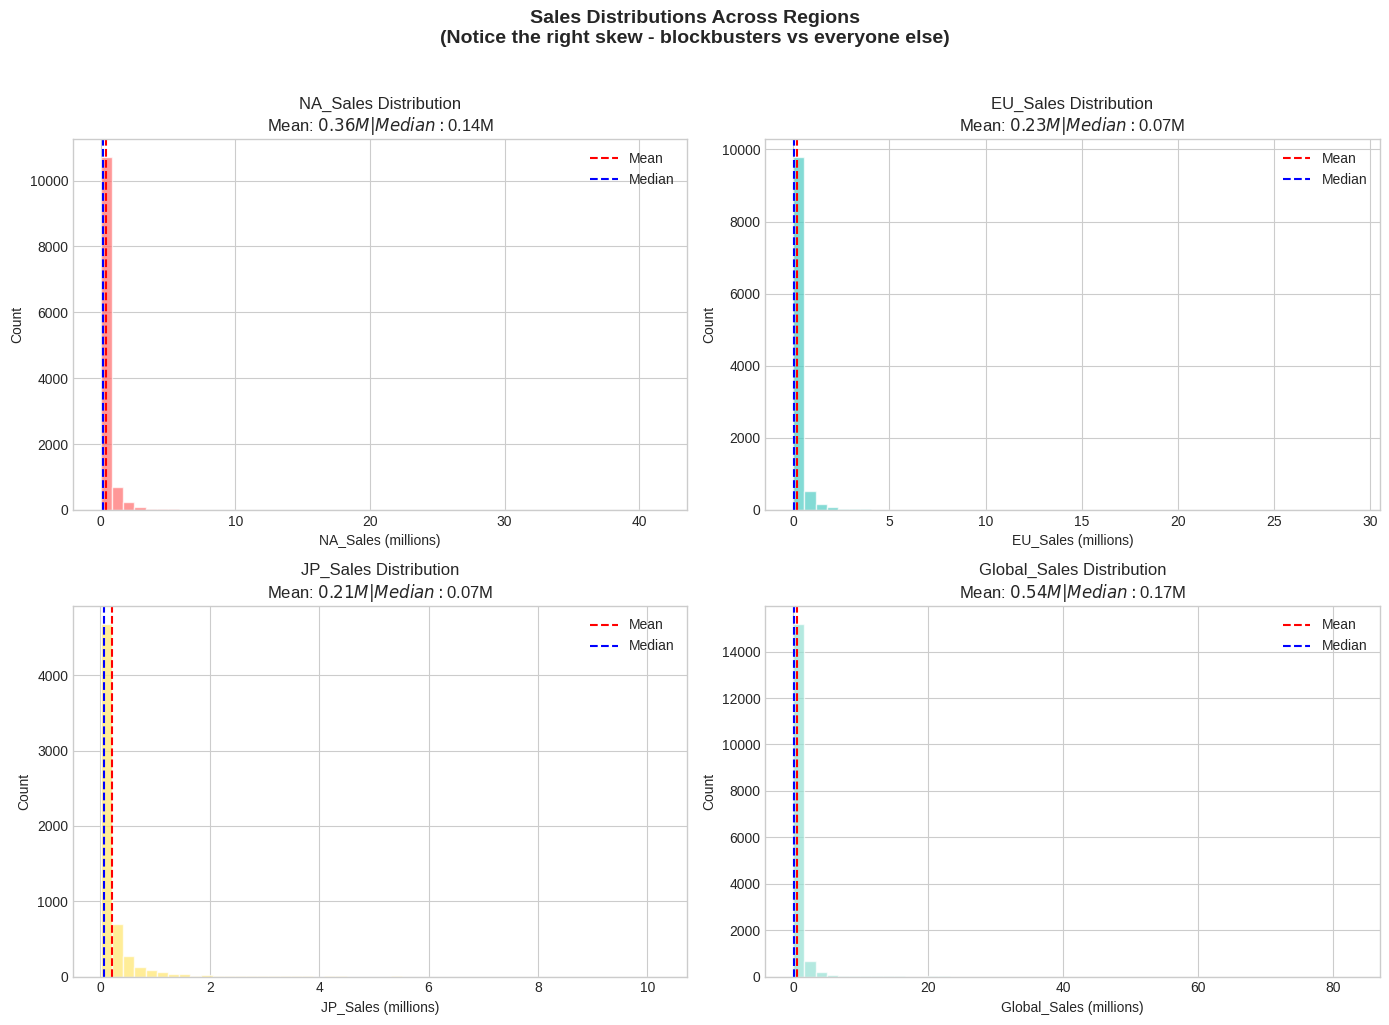


Thought: That mean >> median gap tells the whole story...
A few mega-hits pulling the average way up


In [14]:
# How are sales distributed?
# Betting it's super skewed (few blockbusters, tons of flops)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales']
colors = ['#FF6B6B', '#4ECDC4', '#FFE66D', '#95E1D3']

for idx, (col, color) in enumerate(zip(sales_cols, colors)):
    ax = axes[idx//2, idx%2]

    data = df[col][df[col] > 0]
    ax.hist(data, bins=50, color=color, edgecolor='white', alpha=0.7)
    ax.set_xlabel(f'{col} (millions)')
    ax.set_ylabel('Count')
    ax.set_title(f'{col} Distribution\nMean: ${data.mean():.2f}M | Median: ${data.median():.2f}M')
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean')
    ax.axvline(data.median(), color='blue', linestyle='--', label=f'Median')
    ax.legend()

plt.suptitle('Sales Distributions Across Regions\n(Notice the right skew - blockbusters vs everyone else)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nThought: That mean >> median gap tells the whole story...")
print("A few mega-hits pulling the average way up")

## Log scale view - let's actually SEE the distribution

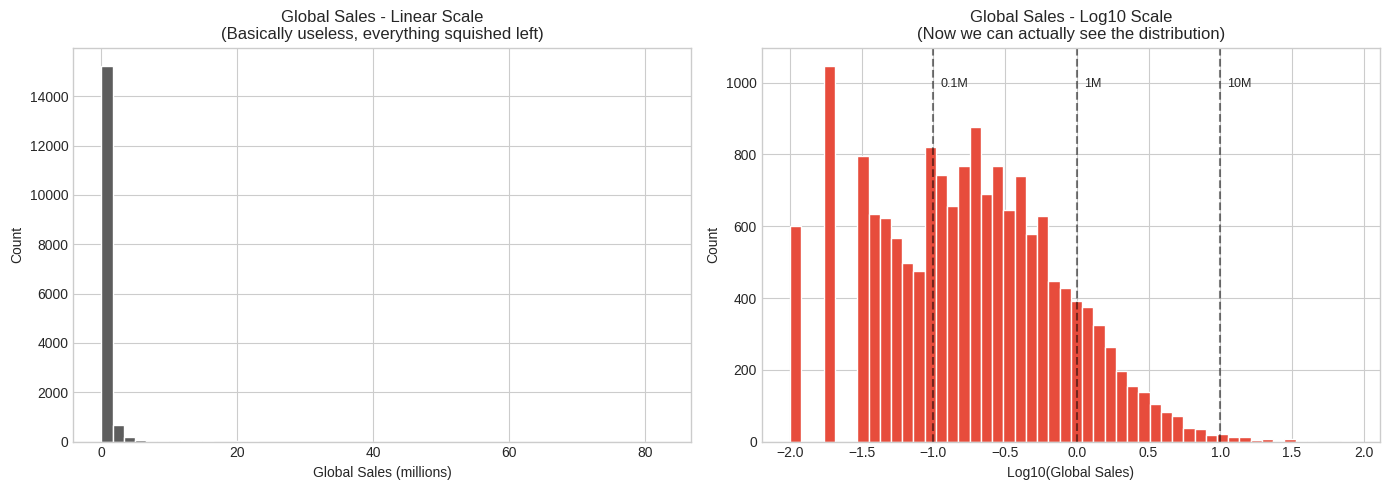

Interesting - log-transformed sales looks roughly normal-ish
Peak seems to be around 0.1-0.2M range (log = -1 to -0.7)


In [15]:
# That last plot was probably useless with all the skew
# Let's do log scale to actually see what's happening

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Raw (probably terrible)
ax1 = axes[0]
ax1.hist(df['Global_Sales'], bins=50, color='#5D5D5D', edgecolor='white')
ax1.set_title('Global Sales - Linear Scale\n(Basically useless, everything squished left)')
ax1.set_xlabel('Global Sales (millions)')
ax1.set_ylabel('Count')

# Right: Log transformed (the real picture)
ax2 = axes[1]
log_sales = np.log10(df['Global_Sales'][df['Global_Sales'] > 0])
ax2.hist(log_sales, bins=50, color='#E74C3C', edgecolor='white')
ax2.set_title('Global Sales - Log10 Scale\n(Now we can actually see the distribution)')
ax2.set_xlabel('Log10(Global Sales)')
ax2.set_ylabel('Count')

# Add reference lines
for val, label in [(0, '1M'), (-1, '0.1M'), (1, '10M')]:
    ax2.axvline(val, color='black', linestyle='--', alpha=0.5)
    ax2.text(val+0.05, ax2.get_ylim()[1]*0.9, label, fontsize=9)

plt.tight_layout()
plt.show()

print("Interesting - log-transformed sales looks roughly normal-ish")
print("Peak seems to be around 0.1-0.2M range (log = -1 to -0.7)")

## Platform evolution over time

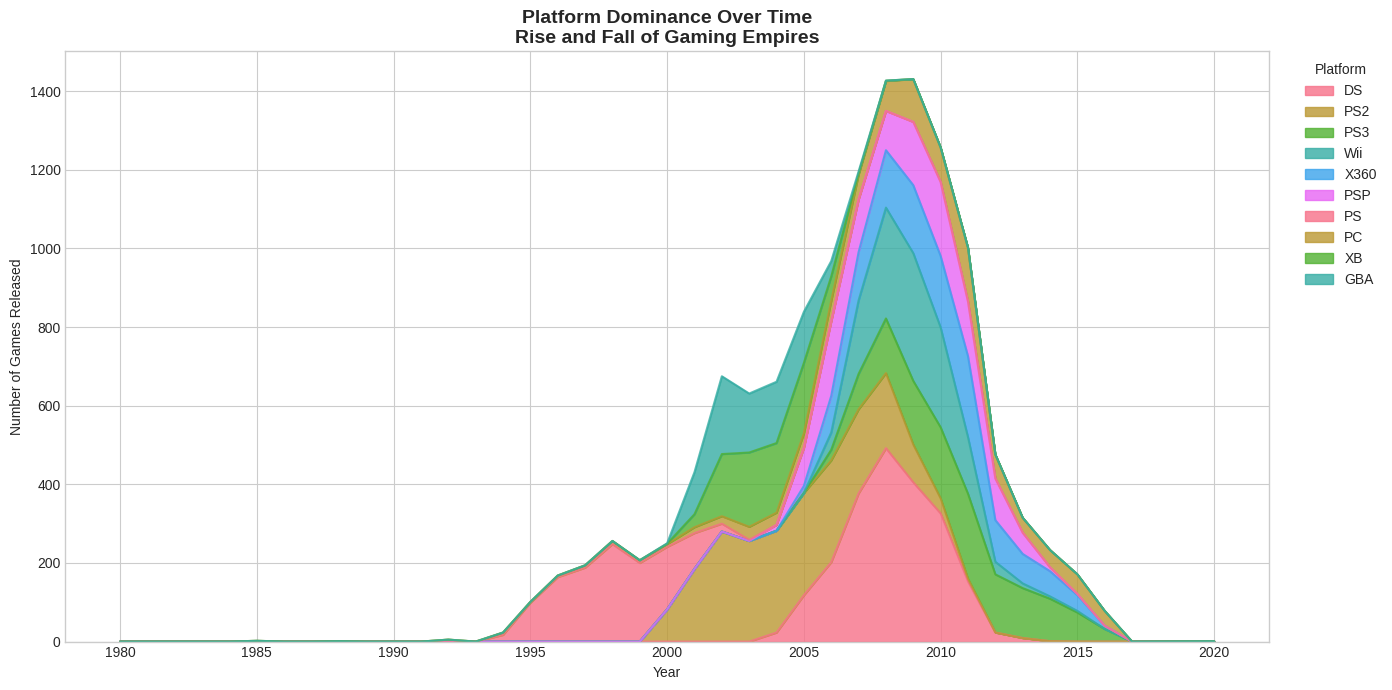


You can literally see console generations here:
- PS2 era dominance (early 2000s)
- DS/Wii explosion (mid-late 2000s)
- PS3/X360 taking over (late 2000s-2010s)


In [16]:
# How has gaming evolved? Which platforms dominated which era?

# Get counts per platform per year
platform_year = df.groupby(['Year', 'Platform']).size().unstack(fill_value=0)

# Top 10 platforms by total games
top_platforms = df['Platform'].value_counts().head(10).index.tolist()

fig, ax = plt.subplots(figsize=(14, 7))

# Stacked area plot for top platforms
platform_year[top_platforms].plot(kind='area', stacked=True, ax=ax, alpha=0.8)

ax.set_title('Platform Dominance Over Time\nRise and Fall of Gaming Empires', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Games Released')
ax.legend(title='Platform', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("\nYou can literally see console generations here:")
print("- PS2 era dominance (early 2000s)")
print("- DS/Wii explosion (mid-late 2000s)")
print("- PS3/X360 taking over (late 2000s-2010s)")

## Genre popularity - what do people actually play?

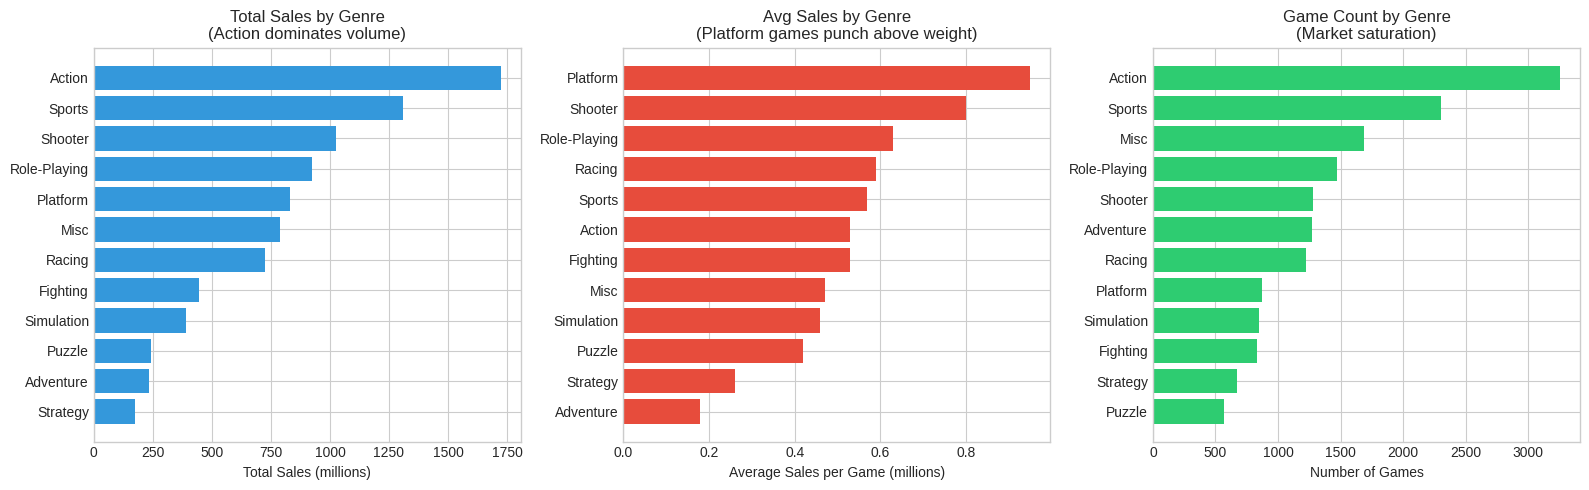


Key insight: Action has most games AND most total sales
But Platform games have highest AVERAGE sales - quality over quantity?
Puzzle games... lots of shovelware maybe? Low avg sales despite decent count


In [17]:
# Genre breakdown by total sales (not just game count)

genre_stats = df.groupby('Genre').agg({
    'Global_Sales': ['sum', 'mean', 'count']
}).round(2)
genre_stats.columns = ['Total_Sales', 'Avg_Sales', 'Game_Count']
genre_stats = genre_stats.sort_values('Total_Sales', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Total sales by genre
ax1 = axes[0]
bars1 = ax1.barh(genre_stats.index, genre_stats['Total_Sales'], color='#3498DB')
ax1.set_xlabel('Total Sales (millions)')
ax1.set_title('Total Sales by Genre\n(Action dominates volume)')
ax1.invert_yaxis()

# Average sales per game
ax2 = axes[1]
avg_sorted = genre_stats.sort_values('Avg_Sales', ascending=False)
bars2 = ax2.barh(avg_sorted.index, avg_sorted['Avg_Sales'], color='#E74C3C')
ax2.set_xlabel('Average Sales per Game (millions)')
ax2.set_title('Avg Sales by Genre\n(Platform games punch above weight)')
ax2.invert_yaxis()

# Game count
ax3 = axes[2]
count_sorted = genre_stats.sort_values('Game_Count', ascending=False)
bars3 = ax3.barh(count_sorted.index, count_sorted['Game_Count'], color='#2ECC71')
ax3.set_xlabel('Number of Games')
ax3.set_title('Game Count by Genre\n(Market saturation)')
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nKey insight: Action has most games AND most total sales")
print("But Platform games have highest AVERAGE sales - quality over quantity?")
print("Puzzle games... lots of shovelware maybe? Low avg sales despite decent count")

## Regional preferences - do different regions like different games?

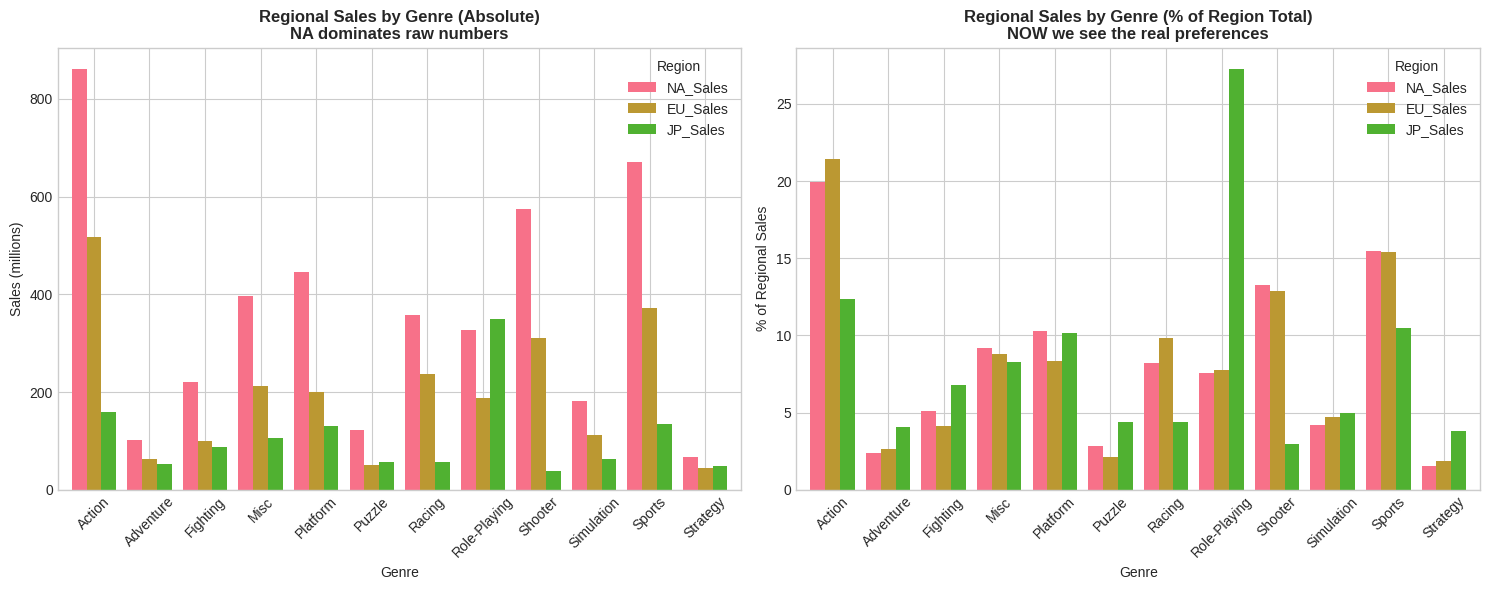


Spotting some patterns here...
JP seems to love Role-Playing way more than NA/EU
NA/EU more into Shooters and Sports


In [18]:
# This is where it gets interesting
# NA vs EU vs JP - do they have different tastes?

# Regional sales by genre
regional_genre = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales']].sum()

# Normalize to percentages (what % of each region's spending goes to each genre)
regional_pct = regional_genre.div(regional_genre.sum()) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Absolute values
ax1 = axes[0]
regional_genre.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Regional Sales by Genre (Absolute)\nNA dominates raw numbers', fontweight='bold')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Sales (millions)')
ax1.legend(title='Region')
ax1.tick_params(axis='x', rotation=45)

# Percentage breakdown - this tells the real story
ax2 = axes[1]
regional_pct.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Regional Sales by Genre (% of Region Total)\nNOW we see the real preferences', fontweight='bold')
ax2.set_xlabel('Genre')
ax2.set_ylabel('% of Regional Sales')
ax2.legend(title='Region')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nSpotting some patterns here...")
print("JP seems to love Role-Playing way more than NA/EU")
print("NA/EU more into Shooters and Sports")

## Let's quantify that regional difference

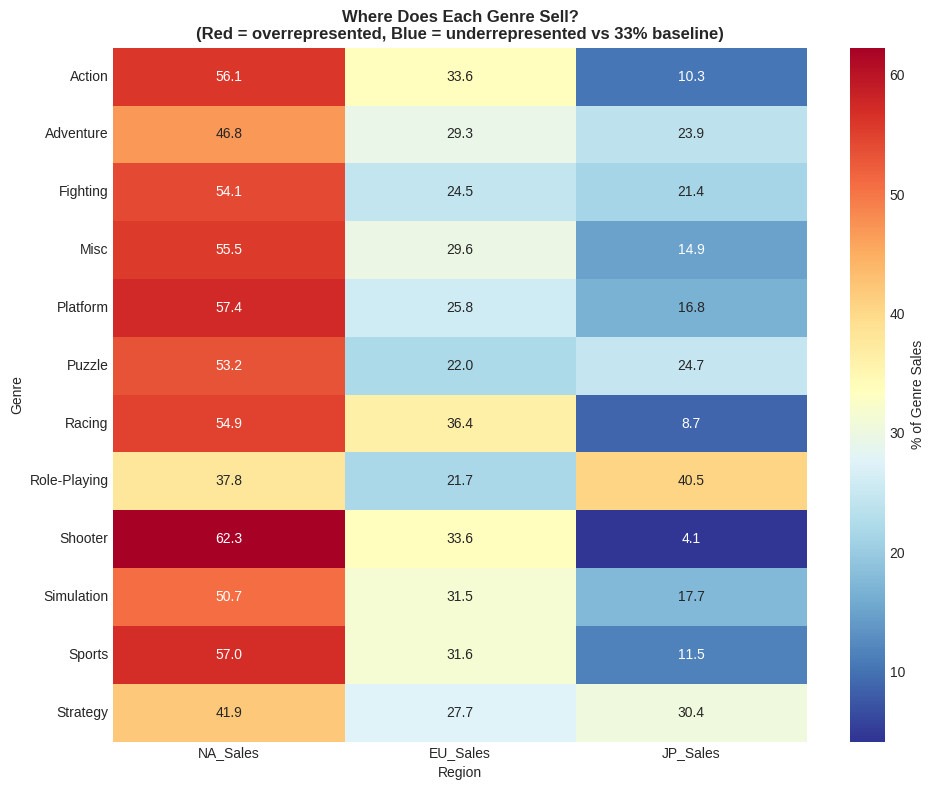


Clear cultural differences:
- Role-Playing: JP at 40.5% (they LOVE their JRPGs)
- Shooter: NA at 62.3% (Call of Duty nation)
- Fighting games also big in JP


In [19]:
# Heatmap of regional preferences - normalized view

# Calculate what % of each genre's sales comes from each region
genre_regional_share = regional_genre.div(regional_genre.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(genre_regional_share, annot=True, fmt='.1f', cmap='RdYlBu_r',
            center=33.33,  # Center at equal distribution (33% each)
            ax=ax, cbar_kws={'label': '% of Genre Sales'})

ax.set_title('Where Does Each Genre Sell?\n(Red = overrepresented, Blue = underrepresented vs 33% baseline)',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Region')
ax.set_ylabel('Genre')

plt.tight_layout()
plt.show()

print("\nClear cultural differences:")
print("- Role-Playing: JP at {:.1f}% (they LOVE their JRPGs)".format(genre_regional_share.loc['Role-Playing', 'JP_Sales']))
print("- Shooter: NA at {:.1f}% (Call of Duty nation)".format(genre_regional_share.loc['Shooter', 'NA_Sales']))
print("- Fighting games also big in JP")

## Publisher analysis - who runs this industry?

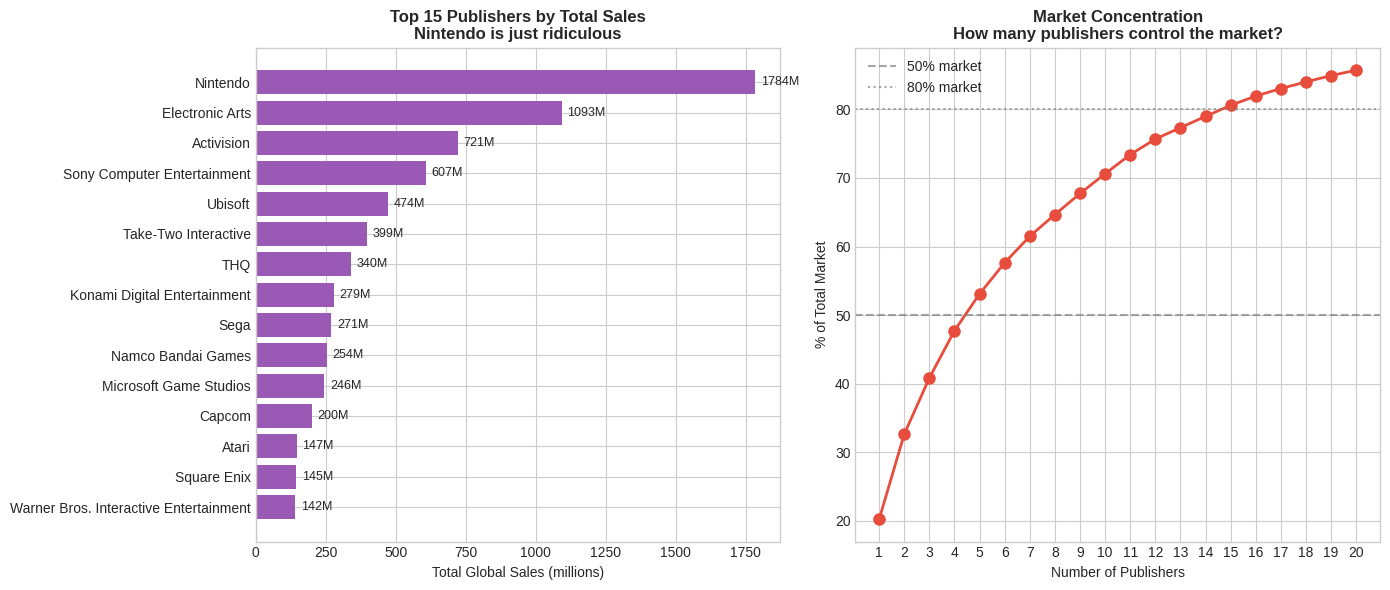


Top 5 publishers control 53.1% of the market
Top 10 publishers control 70.6% of the market
Remaining 566 publishers fight over the scraps


In [20]:
# 576 publishers but I bet it's a total monopoly at the top

publisher_stats = df.groupby('Publisher').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Game_Count'})

publisher_stats['Avg_Sales'] = publisher_stats['Global_Sales'] / publisher_stats['Game_Count']
publisher_stats = publisher_stats.sort_values('Global_Sales', ascending=False)

# Top 15 publishers
top15 = publisher_stats.head(15)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total sales
ax1 = axes[0]
bars = ax1.barh(top15.index[::-1], top15['Global_Sales'][::-1], color='#9B59B6')
ax1.set_xlabel('Total Global Sales (millions)')
ax1.set_title('Top 15 Publishers by Total Sales\nNintendo is just ridiculous', fontweight='bold')

# Add value labels
for bar, val in zip(bars, top15['Global_Sales'][::-1]):
    ax1.text(val + 20, bar.get_y() + bar.get_height()/2, f'{val:.0f}M',
             va='center', fontsize=9)

# Market concentration
ax2 = axes[1]
top_n_share = []
for n in range(1, 21):
    share = publisher_stats.head(n)['Global_Sales'].sum() / publisher_stats['Global_Sales'].sum() * 100
    top_n_share.append(share)

ax2.plot(range(1, 21), top_n_share, 'o-', color='#E74C3C', linewidth=2, markersize=8)
ax2.axhline(50, color='gray', linestyle='--', alpha=0.7, label='50% market')
ax2.axhline(80, color='gray', linestyle=':', alpha=0.7, label='80% market')
ax2.set_xlabel('Number of Publishers')
ax2.set_ylabel('% of Total Market')
ax2.set_title('Market Concentration\nHow many publishers control the market?', fontweight='bold')
ax2.legend()
ax2.set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

print(f"\nTop 5 publishers control {top_n_share[4]:.1f}% of the market")
print(f"Top 10 publishers control {top_n_share[9]:.1f}% of the market")
print(f"Remaining 566 publishers fight over the scraps")

## The long tail of publishers

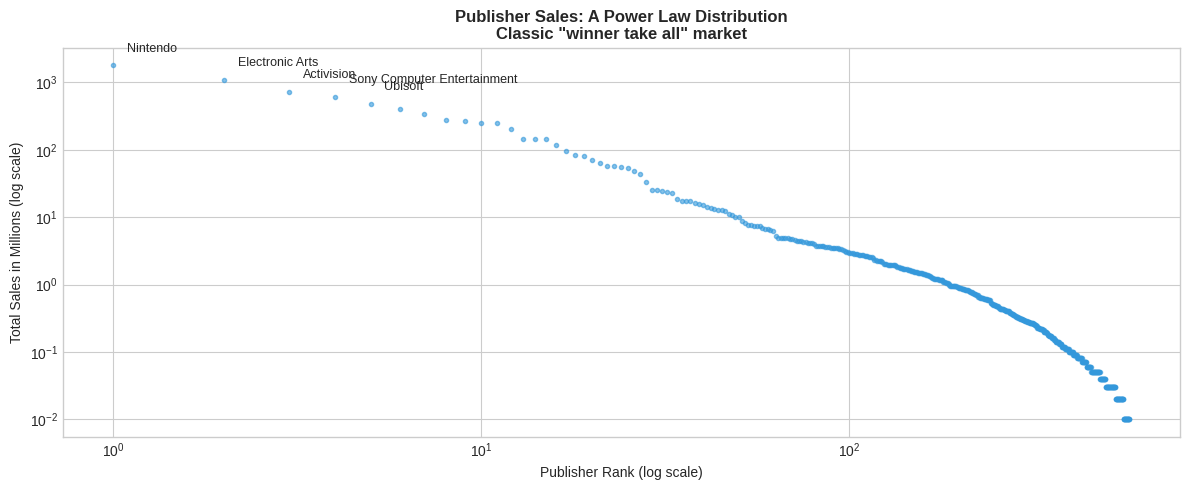


This is basically a power law / Pareto distribution
The gaming industry is BRUTAL for small publishers


In [21]:
# Let's see just how brutal this distribution is

fig, ax = plt.subplots(figsize=(12, 5))

# Rank vs Sales (log scale)
ranks = range(1, len(publisher_stats) + 1)
sales = publisher_stats['Global_Sales'].values

ax.plot(ranks, sales, 'o', markersize=3, alpha=0.6, color='#3498DB')
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Publisher Rank (log scale)')
ax.set_ylabel('Total Sales in Millions (log scale)')
ax.set_title('Publisher Sales: A Power Law Distribution\nClassic "winner take all" market', fontweight='bold')

# Annotate top 5
for i, (pub, row) in enumerate(publisher_stats.head(5).iterrows()):
    ax.annotate(pub, (i+1, row['Global_Sales']),
                xytext=(10, 10), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("\nThis is basically a power law / Pareto distribution")
print("The gaming industry is BRUTAL for small publishers")

## Year-over-year trends

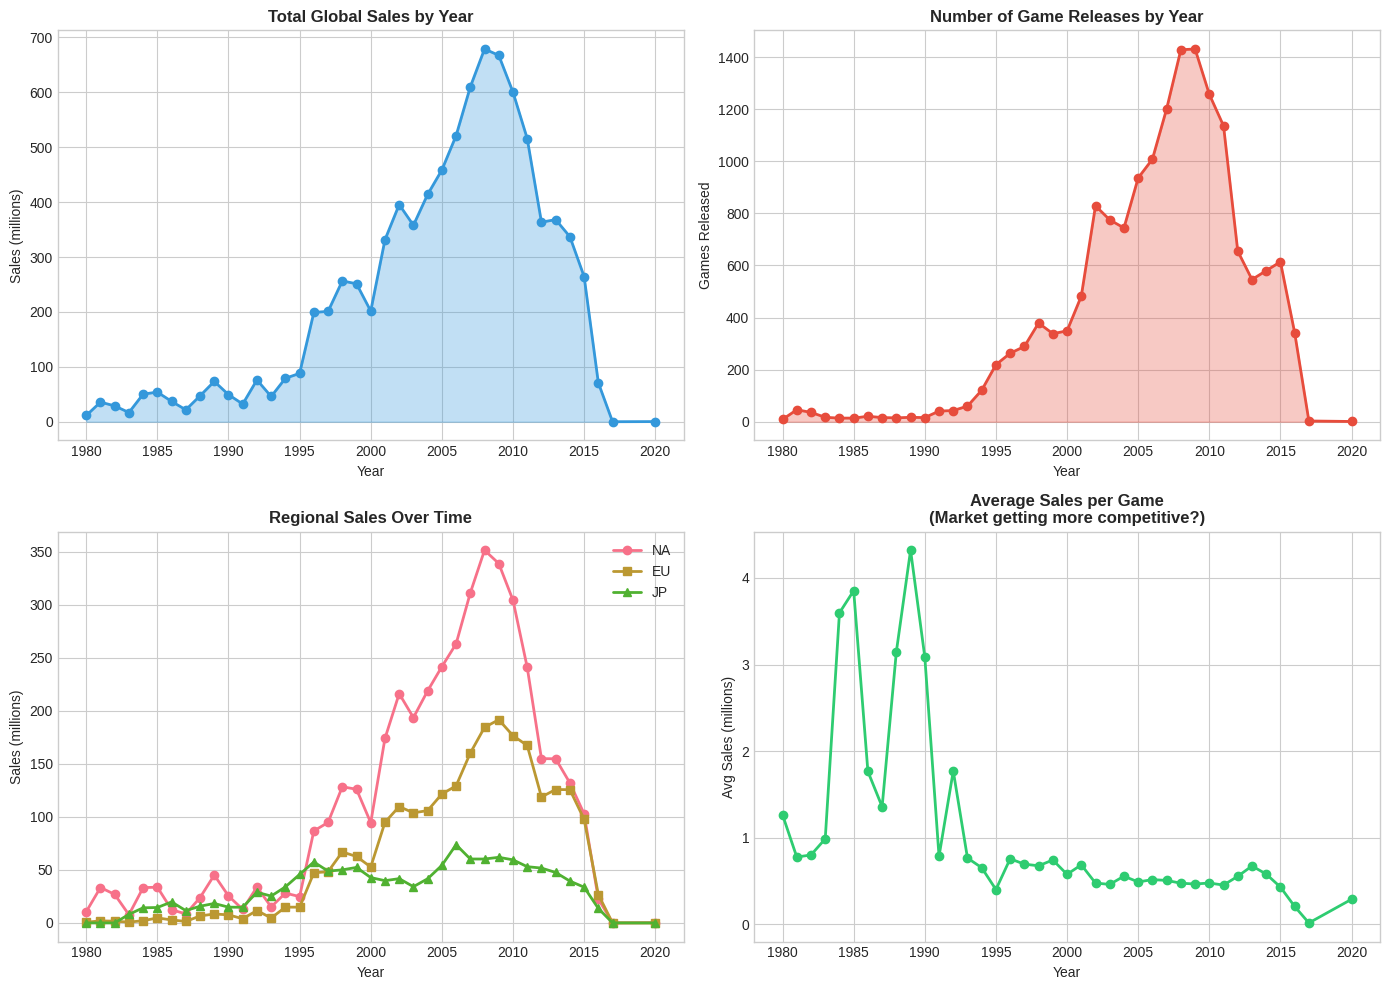


Some thoughts on what I'm seeing:
- Peak seems to be around 2008-2009 (PS3/X360/Wii golden era)
- Sharp decline after 2010... mobile gaming eating market share?
- Or maybe this dataset just has incomplete recent data
- JP market seems more stable, NA/EU more volatile


In [22]:
# How has the industry grown (or shrunk)?

yearly_stats = df.groupby('Year').agg({
    'Global_Sales': 'sum',
    'Name': 'count',
    'NA_Sales': 'sum',
    'EU_Sales': 'sum',
    'JP_Sales': 'sum'
}).rename(columns={'Name': 'Game_Count'})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total sales over time
ax1 = axes[0, 0]
ax1.fill_between(yearly_stats.index, yearly_stats['Global_Sales'], alpha=0.3, color='#3498DB')
ax1.plot(yearly_stats.index, yearly_stats['Global_Sales'], 'o-', color='#3498DB', linewidth=2)
ax1.set_title('Total Global Sales by Year', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Sales (millions)')

# Game releases over time
ax2 = axes[0, 1]
ax2.fill_between(yearly_stats.index, yearly_stats['Game_Count'], alpha=0.3, color='#E74C3C')
ax2.plot(yearly_stats.index, yearly_stats['Game_Count'], 'o-', color='#E74C3C', linewidth=2)
ax2.set_title('Number of Game Releases by Year', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Games Released')

# Regional comparison over time
ax3 = axes[1, 0]
ax3.plot(yearly_stats.index, yearly_stats['NA_Sales'], 'o-', label='NA', linewidth=2)
ax3.plot(yearly_stats.index, yearly_stats['EU_Sales'], 's-', label='EU', linewidth=2)
ax3.plot(yearly_stats.index, yearly_stats['JP_Sales'], '^-', label='JP', linewidth=2)
ax3.set_title('Regional Sales Over Time', fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Sales (millions)')
ax3.legend()

# Average sales per game (quality indicator?)
ax4 = axes[1, 1]
yearly_stats['Avg_Sales'] = yearly_stats['Global_Sales'] / yearly_stats['Game_Count']
ax4.plot(yearly_stats.index, yearly_stats['Avg_Sales'], 'o-', color='#2ECC71', linewidth=2)
ax4.set_title('Average Sales per Game\n(Market getting more competitive?)', fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Avg Sales (millions)')

plt.tight_layout()
plt.show()

print("\nSome thoughts on what I'm seeing:")
print("- Peak seems to be around 2008-2009 (PS3/X360/Wii golden era)")
print("- Sharp decline after 2010... mobile gaming eating market share?")
print("- Or maybe this dataset just has incomplete recent data")
print("- JP market seems more stable, NA/EU more volatile")

## Top games deep dive - what makes a blockbuster?

In [23]:
# Let's look at the absolute top performers
# What do the mega-hits have in common?

top_50 = df.nlargest(50, 'Global_Sales')[['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales']]

print("TOP 20 BEST-SELLING GAMES OF ALL TIME")
print("="*80)
print(top_50.head(20).to_string(index=False))

print("\n" + "="*80)
print("\nBREAKDOWN OF TOP 50 GAMES:")
print("-"*40)
print("\nBy Genre:")
print(top_50['Genre'].value_counts())
print("\nBy Publisher:")
print(top_50['Publisher'].value_counts())
print("\nBy Platform:")
print(top_50['Platform'].value_counts())

TOP 20 BEST-SELLING GAMES OF ALL TIME
                                        Name Platform   Year        Genre              Publisher  Global_Sales  NA_Sales  EU_Sales  JP_Sales
                                  Wii Sports      Wii 2006.0       Sports               Nintendo         82.74     41.49     29.02      3.77
                           Super Mario Bros.      NES 1985.0     Platform               Nintendo         40.24     29.08      3.58      6.81
                              Mario Kart Wii      Wii 2008.0       Racing               Nintendo         35.82     15.85     12.88      3.79
                           Wii Sports Resort      Wii 2009.0       Sports               Nintendo         33.00     15.75     11.01      3.28
                    Pokemon Red/Pokemon Blue       GB 1996.0 Role-Playing               Nintendo         31.37     11.27      8.89     10.22
                                      Tetris       GB 1989.0       Puzzle               Nintendo         30.26     2

## Visualizing what makes top games special

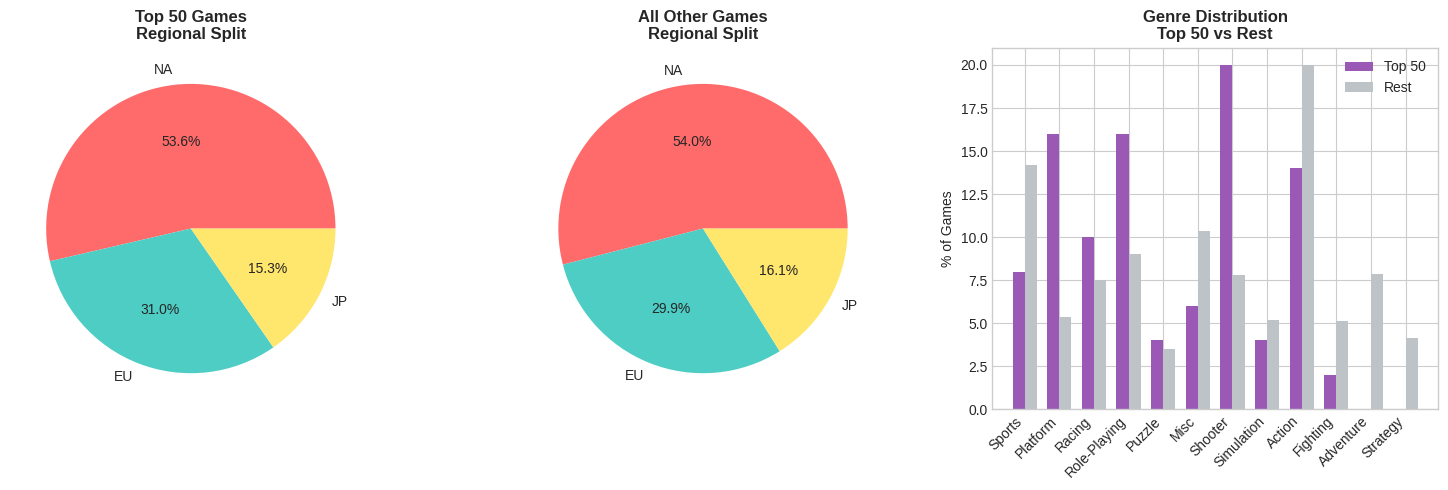


Observations:
- Top games seem to have broader regional appeal (more balanced?)
- Certain genres overrepresented in top 50
- Platform and Sports games punch above their weight in top sellers


In [24]:
# Are top games different in their regional split?

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Compare regional split: Top 50 vs Rest
top_50_games = df.nlargest(50, 'Global_Sales')
rest = df.iloc[50:]

# Regional proportions
def get_regional_props(data):
    total_na = data['NA_Sales'].sum()
    total_eu = data['EU_Sales'].sum()
    total_jp = data['JP_Sales'].sum()
    total = total_na + total_eu + total_jp
    return [total_na/total*100, total_eu/total*100, total_jp/total*100]

top_props = get_regional_props(top_50_games)
rest_props = get_regional_props(rest)

# Pie charts comparison
ax1 = axes[0]
ax1.pie(top_props, labels=['NA', 'EU', 'JP'], autopct='%.1f%%',
        colors=['#FF6B6B', '#4ECDC4', '#FFE66D'])
ax1.set_title('Top 50 Games\nRegional Split', fontweight='bold')

ax2 = axes[1]
ax2.pie(rest_props, labels=['NA', 'EU', 'JP'], autopct='%.1f%%',
        colors=['#FF6B6B', '#4ECDC4', '#FFE66D'])
ax2.set_title('All Other Games\nRegional Split', fontweight='bold')

# Genre comparison
ax3 = axes[2]
x = np.arange(len(df['Genre'].unique()))
width = 0.35

top_genre_pct = top_50_games['Genre'].value_counts(normalize=True) * 100
rest_genre_pct = rest['Genre'].value_counts(normalize=True) * 100

# Align genres
all_genres = df['Genre'].unique()
top_vals = [top_genre_pct.get(g, 0) for g in all_genres]
rest_vals = [rest_genre_pct.get(g, 0) for g in all_genres]

bars1 = ax3.bar(x - width/2, top_vals, width, label='Top 50', color='#9B59B6')
bars2 = ax3.bar(x + width/2, rest_vals, width, label='Rest', color='#BDC3C7')

ax3.set_ylabel('% of Games')
ax3.set_title('Genre Distribution\nTop 50 vs Rest', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(all_genres, rotation=45, ha='right')
ax3.legend()

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Top games seem to have broader regional appeal (more balanced?)")
print("- Certain genres overrepresented in top 50")
print("- Platform and Sports games punch above their weight in top sellers")

## Correlation analysis - how do regional sales relate?

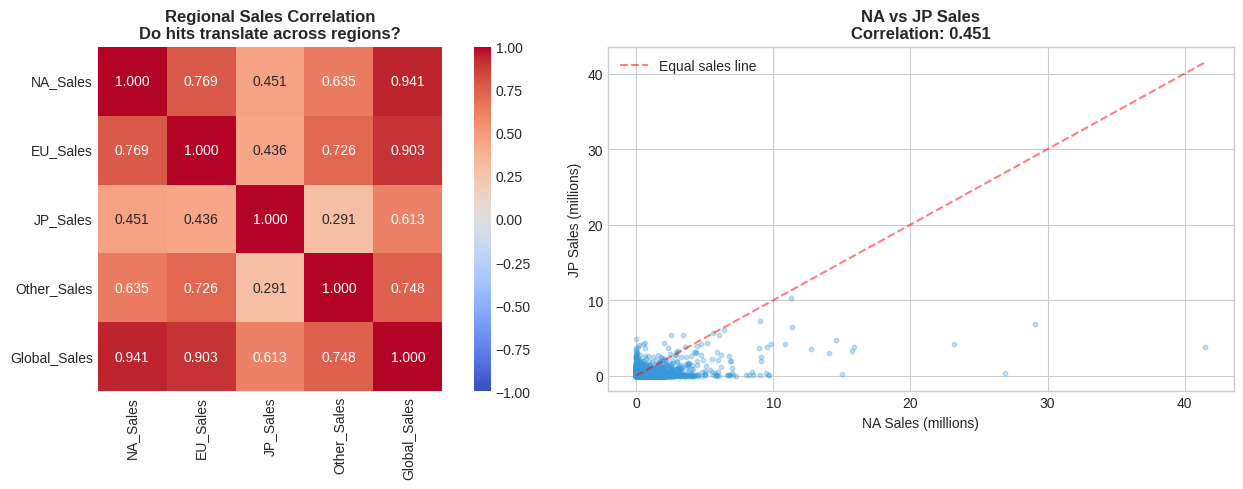


This is fascinating:
- NA-EU correlation: 0.769 (Western markets move together)
- NA-JP correlation: 0.451 (Different tastes!)
- EU-JP correlation: 0.436

Japan really is its own market with different preferences


In [25]:
# Do games that sell well in NA also sell well in EU? What about JP?

sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# Correlation matrix
corr_matrix = df[sales_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
ax1 = axes[0]
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Regional Sales Correlation\nDo hits translate across regions?', fontweight='bold')

# Scatter matrix for the interesting pairs
ax2 = axes[1]
ax2.scatter(df['NA_Sales'], df['JP_Sales'], alpha=0.3, s=10, c='#3498DB')
ax2.set_xlabel('NA Sales (millions)')
ax2.set_ylabel('JP Sales (millions)')
ax2.set_title(f'NA vs JP Sales\nCorrelation: {df["NA_Sales"].corr(df["JP_Sales"]):.3f}', fontweight='bold')

# Add diagonal reference
max_val = max(df['NA_Sales'].max(), df['JP_Sales'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal sales line')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nThis is fascinating:")
print(f"- NA-EU correlation: {corr_matrix.loc['NA_Sales', 'EU_Sales']:.3f} (Western markets move together)")
print(f"- NA-JP correlation: {corr_matrix.loc['NA_Sales', 'JP_Sales']:.3f} (Different tastes!)")
print(f"- EU-JP correlation: {corr_matrix.loc['EU_Sales', 'JP_Sales']:.3f}")
print("\nJapan really is its own market with different preferences")

## Simpson's Paradox Hunt - this is where it gets spicy

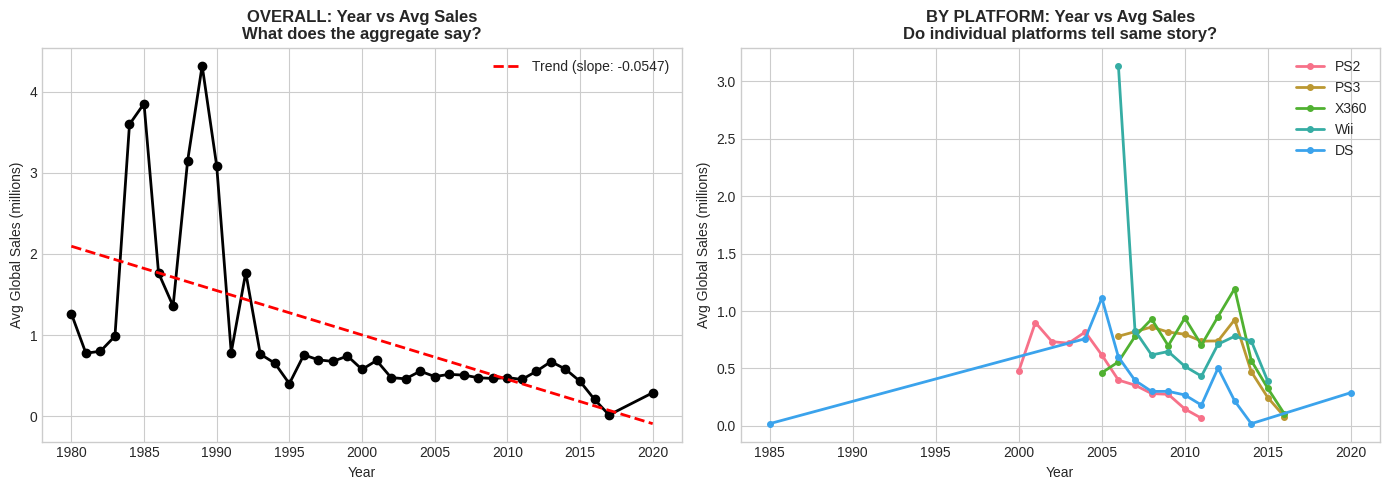


Looking for Simpson's Paradox...
If overall trend goes DOWN but individual platforms go UP (or vice versa)
That would be Simpson's Paradox in action


In [26]:
# Time for my favorite analysis
# Simpson's Paradox: when trends reverse after controlling for a variable
#
# Hypothesis: Maybe a genre looks "worse" overall but is actually better
# within specific platforms or regions

# Let's check: Does the relationship between Year and Sales
# reverse when we control for Platform?

# Overall trend: Year vs Avg Sales
yearly_avg = df.groupby('Year')['Global_Sales'].mean()

# Now by platform
top_platforms = ['PS2', 'PS3', 'X360', 'Wii', 'DS']
platform_yearly = df[df['Platform'].isin(top_platforms)].groupby(['Year', 'Platform'])['Global_Sales'].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall trend
ax1 = axes[0]
ax1.plot(yearly_avg.index, yearly_avg.values, 'ko-', linewidth=2, markersize=6)
z = np.polyfit(yearly_avg.index.astype(float), yearly_avg.values, 1)
p = np.poly1d(z)
ax1.plot(yearly_avg.index, p(yearly_avg.index), 'r--', linewidth=2, label=f'Trend (slope: {z[0]:.4f})')
ax1.set_title('OVERALL: Year vs Avg Sales\nWhat does the aggregate say?', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Global Sales (millions)')
ax1.legend()

# By platform
ax2 = axes[1]
for platform in top_platforms:
    data = platform_yearly[platform].dropna()
    if len(data) > 3:
        ax2.plot(data.index, data.values, 'o-', label=platform, linewidth=2, markersize=4)

ax2.set_title('BY PLATFORM: Year vs Avg Sales\nDo individual platforms tell same story?', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Avg Global Sales (millions)')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nLooking for Simpson's Paradox...")
print("If overall trend goes DOWN but individual platforms go UP (or vice versa)")
print("That would be Simpson's Paradox in action")

## Simpson's Paradox - Regional edition

In [27]:
# Another angle: Genre performance by region
# Does a genre that looks "bad" in aggregate actually perform well in specific regions?

# Calculate: For each genre, what's the avg sales overall vs by region?
genre_overall = df.groupby('Genre')['Global_Sales'].mean().sort_values(ascending=False)

genre_by_region = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales']].mean()

# Rank each genre within each view
overall_rank = genre_overall.rank(ascending=False)
na_rank = genre_by_region['NA_Sales'].rank(ascending=False)
eu_rank = genre_by_region['EU_Sales'].rank(ascending=False)
jp_rank = genre_by_region['JP_Sales'].rank(ascending=False)

rank_comparison = pd.DataFrame({
    'Overall_Rank': overall_rank,
    'NA_Rank': na_rank,
    'EU_Rank': eu_rank,
    'JP_Rank': jp_rank,
    'Overall_Avg': genre_overall,
    'NA_Avg': genre_by_region['NA_Sales'],
    'EU_Avg': genre_by_region['EU_Sales'],
    'JP_Avg': genre_by_region['JP_Sales']
}).sort_values('Overall_Rank')

print("GENRE RANKINGS: Overall vs By Region")
print("="*70)
print(rank_comparison[['Overall_Rank', 'NA_Rank', 'EU_Rank', 'JP_Rank']].to_string())

print("\n" + "="*70)
print("\nLOOKING FOR RANK REVERSALS (potential Simpson's Paradox):")
print("-"*70)

for genre in rank_comparison.index:
    overall = rank_comparison.loc[genre, 'Overall_Rank']
    jp = rank_comparison.loc[genre, 'JP_Rank']
    na = rank_comparison.loc[genre, 'NA_Rank']

    # Flag big discrepancies
    if abs(overall - jp) >= 4 or abs(overall - na) >= 4:
        print(f"\n{genre}:")
        print(f"  Overall Rank: {overall:.0f} | NA Rank: {na:.0f} | JP Rank: {jp:.0f}")
        if jp < overall:
            print(f"  --> Performs BETTER in Japan than overall ranking suggests!")
        if na < overall:
            print(f"  --> Performs BETTER in NA than overall ranking suggests!")

GENRE RANKINGS: Overall vs By Region
              Overall_Rank  NA_Rank  EU_Rank  JP_Rank
Genre                                                
Platform               1.0      1.0      2.0      2.0
Shooter                2.0      2.0      1.0     12.0
Role-Playing           3.0      8.0      7.0      1.0
Racing                 4.0      3.0      3.0     10.0
Sports                 5.0      4.0      4.0      8.0
Fighting               6.0      6.0      9.0      3.0
Action                 7.0      5.0      5.0      9.0
Misc                   8.0      7.0      8.0      7.0
Simulation             9.0      9.0      6.0      5.0
Puzzle                10.0     10.0     10.0      4.0
Strategy              11.0     11.0     11.0      6.0
Adventure             12.0     12.0     12.0     11.0


LOOKING FOR RANK REVERSALS (potential Simpson's Paradox):
----------------------------------------------------------------------

Shooter:
  Overall Rank: 2 | NA Rank: 2 | JP Rank: 12

Role-Playing:
  Over

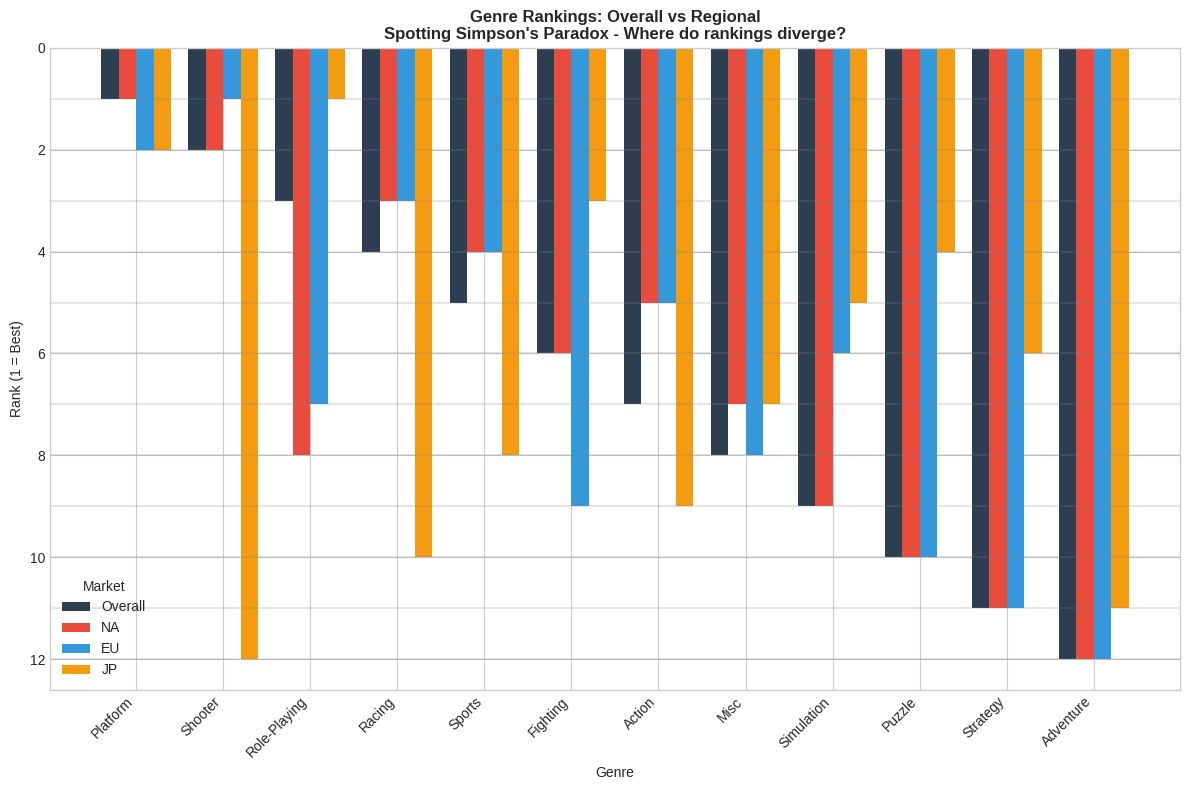


Key Insight:
Notice how Role-Playing and Fighting have VERY different ranks in JP vs Overall
This is Simpson's Paradox territory - the aggregate hides regional truths


In [28]:
# Let's make this visual

fig, ax = plt.subplots(figsize=(12, 8))

genres = rank_comparison.index
x = np.arange(len(genres))
width = 0.2

bars1 = ax.bar(x - 1.5*width, rank_comparison['Overall_Rank'], width, label='Overall', color='#2C3E50')
bars2 = ax.bar(x - 0.5*width, rank_comparison['NA_Rank'], width, label='NA', color='#E74C3C')
bars3 = ax.bar(x + 0.5*width, rank_comparison['EU_Rank'], width, label='EU', color='#3498DB')
bars4 = ax.bar(x + 1.5*width, rank_comparison['JP_Rank'], width, label='JP', color='#F39C12')

ax.set_ylabel('Rank (1 = Best)')
ax.set_xlabel('Genre')
ax.set_title('Genre Rankings: Overall vs Regional\nSpotting Simpson\'s Paradox - Where do rankings diverge?',
             fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right')
ax.legend(title='Market')
ax.invert_yaxis()  # Lower rank = better, so invert

# Add horizontal line at each rank for reference
for i in range(1, 13):
    ax.axhline(y=i, color='gray', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("Notice how Role-Playing and Fighting have VERY different ranks in JP vs Overall")
print("This is Simpson's Paradox territory - the aggregate hides regional truths")

## Quantifying the Simpson's Paradox

In [29]:
# Let's make this crystal clear with actual numbers

print("SIMPSON'S PARADOX DEEP DIVE")
print("="*70)
print("\nThe question: Is Role-Playing a 'mid' genre or a 'top' genre?")
print("-"*70)

rp_data = df[df['Genre'] == 'Role-Playing']
shooter_data = df[df['Genre'] == 'Shooter']

print("\nROLE-PLAYING GAMES:")
print(f"  Overall Avg Sales:  ${rp_data['Global_Sales'].mean():.3f}M (Rank #3)")
print(f"  NA Avg Sales:       ${rp_data['NA_Sales'].mean():.3f}M (Rank #8)")
print(f"  JP Avg Sales:       ${rp_data['JP_Sales'].mean():.3f}M (Rank #1)")

print("\nSHOOTER GAMES:")
print(f"  Overall Avg Sales:  ${shooter_data['Global_Sales'].mean():.3f}M (Rank #2)")
print(f"  NA Avg Sales:       ${shooter_data['NA_Sales'].mean():.3f}M (Rank #2)")
print(f"  JP Avg Sales:       ${shooter_data['JP_Sales'].mean():.3f}M (Rank #12)")

print("\n" + "="*70)
print("THE PARADOX:")
print("-"*70)
print("""
If you're a game developer looking at 'overall' stats:
  "Shooters outsell RPGs, let's make a shooter!"

But if you're targeting the Japanese market:
  "RPGs outsell shooters 3-4x, let's make an RPG!"

The AGGREGATE HIDES THE TRUTH because NA/EU market size
dominates the global numbers, making it look like shooters
are universally better when they're actually regional.

This is Simpson's Paradox: the trend REVERSES when you
control for region.
""")

SIMPSON'S PARADOX DEEP DIVE

The question: Is Role-Playing a 'mid' genre or a 'top' genre?
----------------------------------------------------------------------

ROLE-PLAYING GAMES:
  Overall Avg Sales:  $0.628M (Rank #3)
  NA Avg Sales:       $0.222M (Rank #8)
  JP Avg Sales:       $0.238M (Rank #1)

SHOOTER GAMES:
  Overall Avg Sales:  $0.800M (Rank #2)
  NA Avg Sales:       $0.449M (Rank #2)
  JP Avg Sales:       $0.030M (Rank #12)

THE PARADOX:
----------------------------------------------------------------------

If you're a game developer looking at 'overall' stats:
  "Shooters outsell RPGs, let's make a shooter!"

But if you're targeting the Japanese market:
  "RPGs outsell shooters 3-4x, let's make an RPG!"

The AGGREGATE HIDES THE TRUTH because NA/EU market size
dominates the global numbers, making it look like shooters
are universally better when they're actually regional.

This is Simpson's Paradox: the trend REVERSES when you
control for region.



## Visual proof of the paradox

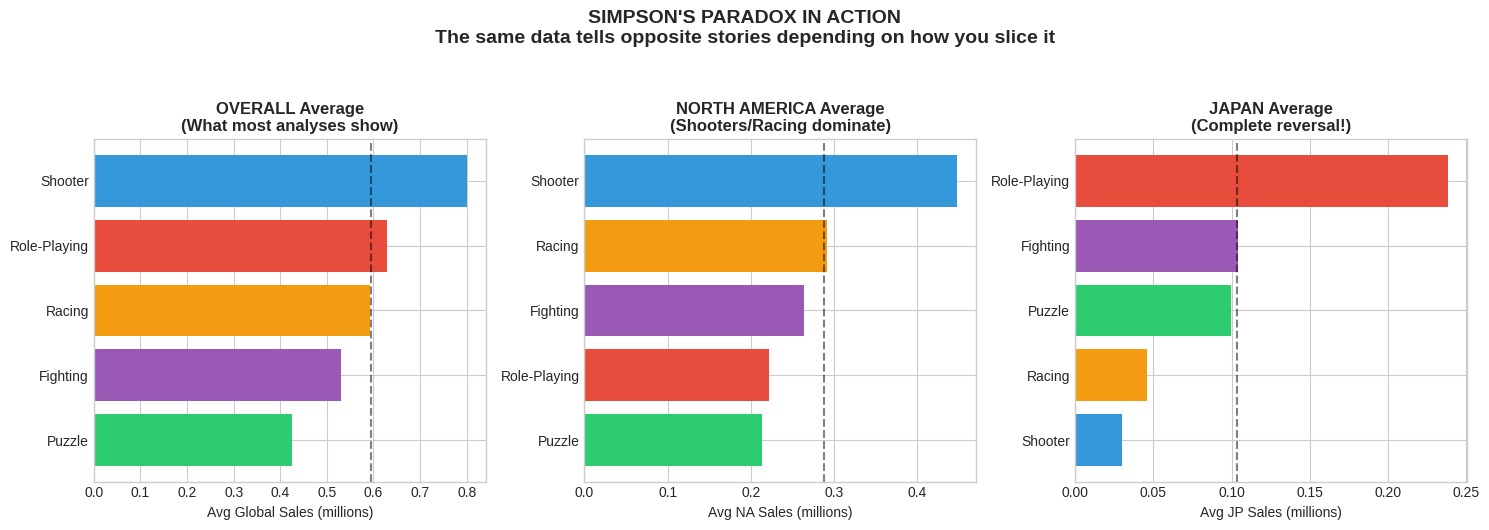


Look at that flip!
Shooter goes from near-top (Overall/NA) to bottom (JP)
Role-Playing goes from middle (NA) to top (JP)


In [30]:
# One killer visualization to drive this home

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Data prep
genres_of_interest = ['Role-Playing', 'Shooter', 'Puzzle', 'Fighting', 'Racing']
colors = {'Role-Playing': '#E74C3C', 'Shooter': '#3498DB', 'Puzzle': '#2ECC71',
          'Fighting': '#9B59B6', 'Racing': '#F39C12'}

# Chart 1: Overall avg (the "lie")
ax1 = axes[0]
overall_avgs = df.groupby('Genre')['Global_Sales'].mean()[genres_of_interest].sort_values(ascending=True)
bars1 = ax1.barh(overall_avgs.index, overall_avgs.values, color=[colors[g] for g in overall_avgs.index])
ax1.set_xlabel('Avg Global Sales (millions)')
ax1.set_title('OVERALL Average\n(What most analyses show)', fontweight='bold')
ax1.axvline(overall_avgs.mean(), color='black', linestyle='--', alpha=0.5)

# Chart 2: NA avg
ax2 = axes[1]
na_avgs = df.groupby('Genre')['NA_Sales'].mean()[genres_of_interest].sort_values(ascending=True)
bars2 = ax2.barh(na_avgs.index, na_avgs.values, color=[colors[g] for g in na_avgs.index])
ax2.set_xlabel('Avg NA Sales (millions)')
ax2.set_title('NORTH AMERICA Average\n(Shooters/Racing dominate)', fontweight='bold')
ax2.axvline(na_avgs.mean(), color='black', linestyle='--', alpha=0.5)

# Chart 3: JP avg (the reversal!)
ax3 = axes[2]
jp_avgs = df.groupby('Genre')['JP_Sales'].mean()[genres_of_interest].sort_values(ascending=True)
bars3 = ax3.barh(jp_avgs.index, jp_avgs.values, color=[colors[g] for g in jp_avgs.index])
ax3.set_xlabel('Avg JP Sales (millions)')
ax3.set_title('JAPAN Average\n(Complete reversal!)', fontweight='bold')
ax3.axvline(jp_avgs.mean(), color='black', linestyle='--', alpha=0.5)

plt.suptitle("SIMPSON'S PARADOX IN ACTION\nThe same data tells opposite stories depending on how you slice it",
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("\nLook at that flip!")
print("Shooter goes from near-top (Overall/NA) to bottom (JP)")
print("Role-Playing goes from middle (NA) to top (JP)")

## The confounding variable explained

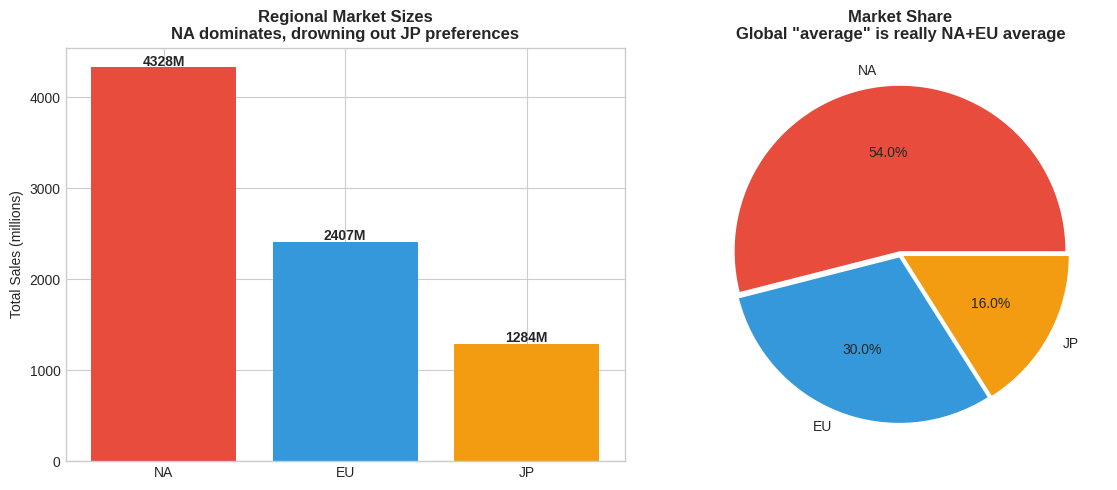


NA + EU = 84.0% of global market
JP = only 16.0% of global market

So 'global trends' are basically Western trends with JP being statistical noise
That's why Simpson's Paradox appears - JP has different tastes but tiny weight


In [31]:
# Why does this happen? Market size is the confounding variable

market_sizes = df[['NA_Sales', 'EU_Sales', 'JP_Sales']].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Market size comparison
ax1 = axes[0]
bars = ax1.bar(['NA', 'EU', 'JP'], market_sizes.values, color=['#E74C3C', '#3498DB', '#F39C12'])
ax1.set_ylabel('Total Sales (millions)')
ax1.set_title('Regional Market Sizes\nNA dominates, drowning out JP preferences', fontweight='bold')

for bar, val in zip(bars, market_sizes.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 20,
             f'{val:.0f}M', ha='center', fontweight='bold')

# Show the weight of each market
ax2 = axes[1]
weights = market_sizes / market_sizes.sum() * 100
ax2.pie(weights, labels=['NA', 'EU', 'JP'], autopct='%.1f%%',
        colors=['#E74C3C', '#3498DB', '#F39C12'],
        explode=[0.02, 0.02, 0.02])
ax2.set_title('Market Share\nGlobal "average" is really NA+EU average', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nNA + EU = {(weights['NA_Sales'] + weights['EU_Sales']):.1f}% of global market")
print(f"JP = only {weights['JP_Sales']:.1f}% of global market")
print("\nSo 'global trends' are basically Western trends with JP being statistical noise")
print("That's why Simpson's Paradox appears - JP has different tastes but tiny weight")

## Transition to Modeling - what can we predict?

In [32]:
# Alright, EDA has been fun but let's build some models
#
# What's a useful prediction problem here?
#
# Option 1: Predict Global_Sales (regression)
# Option 2: Classify games into "hit" vs "flop" (classification)
# Option 3: Predict which region will like a game most
#
# I'll go with a mix - regression for sales + classification for "hit" status

print("MODELING SETUP")
print("="*70)

# Define what makes a "hit"
# Let's say top 25% of sales = hit
threshold = df['Global_Sales'].quantile(0.75)
df['Is_Hit'] = (df['Global_Sales'] >= threshold).astype(int)

print(f"\nHit threshold (75th percentile): ${threshold:.2f}M")
print(f"Hit games: {df['Is_Hit'].sum()} ({df['Is_Hit'].mean()*100:.1f}%)")
print(f"Non-hits: {(1-df['Is_Hit']).sum()} ({(1-df['Is_Hit']).mean()*100:.1f}%)")

print("\n" + "-"*70)
print("Features we can use:")
print("  - Platform (categorical)")
print("  - Genre (categorical)")
print("  - Publisher (categorical - but 576 is too many, we'll bucket)")
print("  - Year (numerical)")
print("\nTarget variables:")
print("  - Global_Sales (regression)")
print("  - Is_Hit (classification)")

MODELING SETUP

Hit threshold (75th percentile): $0.48M
Hit games: 4087 (25.1%)
Non-hits: 12204 (74.9%)

----------------------------------------------------------------------
Features we can use:
  - Platform (categorical)
  - Genre (categorical)
  - Publisher (categorical - but 576 is too many, we'll bucket)
  - Year (numerical)

Target variables:
  - Global_Sales (regression)
  - Is_Hit (classification)


## Feature Engineering

In [33]:
# Prep features for modeling

from sklearn.preprocessing import LabelEncoder

# Create a copy for modeling
model_df = df.copy()

# Handle Year - fill any NaN with median (you said no NaN but just in case)
model_df['Year'] = model_df['Year'].fillna(model_df['Year'].median())

# Publisher bucketing - top 20 get their own category, rest = "Other"
top_publishers = model_df['Publisher'].value_counts().head(20).index.tolist()
model_df['Publisher_Grouped'] = model_df['Publisher'].apply(
    lambda x: x if x in top_publishers else 'Other'
)

print("FEATURE ENGINEERING")
print("="*70)

print(f"\nPublisher grouping: {model_df['Publisher'].nunique()} -> {model_df['Publisher_Grouped'].nunique()} categories")

# Create some derived features
# Platform generation/era
def get_platform_era(platform):
    retro = ['2600', 'NES', 'GB', 'SNES', 'GEN']
    ps1_era = ['PS', 'N64', 'SAT', 'GBC']
    ps2_era = ['PS2', 'GC', 'XB', 'GBA', 'DC']
    ps3_era = ['PS3', 'X360', 'Wii', 'DS', 'PSP']
    current = ['PS4', 'XOne', 'WiiU', '3DS', 'PSV', 'PC']

    if platform in retro: return 'Retro'
    elif platform in ps1_era: return 'PS1_Era'
    elif platform in ps2_era: return 'PS2_Era'
    elif platform in ps3_era: return 'PS3_Era'
    else: return 'Modern'

model_df['Platform_Era'] = model_df['Platform'].apply(get_platform_era)

print("\nPlatform Era distribution:")
print(model_df['Platform_Era'].value_counts())

# Nintendo vs Others (Nintendo seems to dominate hits)
nintendo_platforms = ['Wii', 'DS', 'NES', 'GB', 'SNES', '3DS', 'GBA', 'N64', 'GC', 'WiiU']
model_df['Is_Nintendo'] = model_df['Platform'].isin(nintendo_platforms).astype(int)

print(f"\nNintendo platform games: {model_df['Is_Nintendo'].sum()} ({model_df['Is_Nintendo'].mean()*100:.1f}%)")

# Decade feature
model_df['Decade'] = (model_df['Year'] // 10 * 10).astype(int)
print("\nDecade distribution:")
print(model_df['Decade'].value_counts().sort_index())

FEATURE ENGINEERING

Publisher grouping: 576 -> 21 categories

Platform Era distribution:
Platform_Era
PS3_Era    7156
PS2_Era    4310
Modern     2570
PS1_Era    1678
Retro       577
Name: count, dtype: int64

Nintendo platform games: 6141 (37.7%)

Decade distribution:
Decade
1980     205
1990    1769
2000    9183
2010    5133
2020       1
Name: count, dtype: int64


In [34]:
# One-hot encode categoricals for modeling

from sklearn.preprocessing import OneHotEncoder
import scipy.sparse as sp

# Features to encode
cat_features = ['Platform', 'Genre', 'Publisher_Grouped', 'Platform_Era']
num_features = ['Year', 'Is_Nintendo', 'Decade']

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(model_df[cat_features])
encoded_cat_names = encoder.get_feature_names_out(cat_features)

print("ENCODING COMPLETE")
print("="*70)
print(f"\nCategorical features encoded: {len(cat_features)}")
print(f"One-hot encoded columns: {len(encoded_cat_names)}")
print(f"Numerical features: {len(num_features)}")
print(f"Total features: {len(encoded_cat_names) + len(num_features)}")

# Build final feature matrix
X_cat = pd.DataFrame(encoded_cats, columns=encoded_cat_names)
X_num = model_df[num_features].reset_index(drop=True)
X = pd.concat([X_num, X_cat], axis=1)

# Targets
y_reg = model_df['Global_Sales'].values  # For regression
y_clf = model_df['Is_Hit'].values  # For classification

print(f"\nFinal X shape: {X.shape}")
print(f"y_reg shape: {y_reg.shape}")
print(f"y_clf shape: {y_clf.shape}")
print(f"\nClass balance (Is_Hit): {y_clf.mean()*100:.1f}% hits")

ENCODING COMPLETE

Categorical features encoded: 4
One-hot encoded columns: 69
Numerical features: 3
Total features: 72

Final X shape: (16291, 72)
y_reg shape: (16291,)
y_clf shape: (16291,)

Class balance (Is_Hit): 25.1% hits


## Train/Test Split

In [35]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

print("TRAIN/TEST SPLIT")
print("="*70)
print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nTraining set hit rate: {y_train_clf.mean()*100:.1f}%")
print(f"Test set hit rate: {y_test_clf.mean()*100:.1f}%")
print("\nLooks balanced - good to go!")

TRAIN/TEST SPLIT

Training samples: 13032
Test samples: 3259

Training set hit rate: 25.2%
Test set hit rate: 24.8%

Looks balanced - good to go!


## Baseline Models

In [36]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import time

print("BASELINE MODELS")
print("="*70)

# ============ REGRESSION BASELINE ============
print("\n[1] REGRESSION: Predicting Global Sales")
print("-"*50)

lr = LinearRegression()
start = time.time()
lr.fit(X_train, y_train_reg)
lr_time = time.time() - start

y_pred_lr = lr.predict(X_test)
y_pred_lr = np.clip(y_pred_lr, 0, None)  # Sales can't be negative

print(f"Linear Regression (trained in {lr_time:.2f}s)")
print(f"  R2 Score:  {r2_score(y_test_reg, y_pred_lr):.4f}")
print(f"  RMSE:      ${np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)):.3f}M")
print(f"  MAE:       ${mean_absolute_error(y_test_reg, y_pred_lr):.3f}M")

print("\n[2] CLASSIFICATION: Predicting Hit vs Flop")
print("-"*50)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
start = time.time()
log_reg.fit(X_train, y_train_clf)
log_time = time.time() - start

y_pred_log = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

print(f"Logistic Regression (trained in {log_time:.2f}s)")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_pred_log)*100:.2f}%")
print(f"  ROC-AUC:   {roc_auc_score(y_test_clf, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_log, target_names=['Flop', 'Hit']))

BASELINE MODELS

[1] REGRESSION: Predicting Global Sales
--------------------------------------------------
Linear Regression (trained in 0.30s)
  R2 Score:  0.0874
  RMSE:      $1.976M
  MAE:       $0.546M

[2] CLASSIFICATION: Predicting Hit vs Flop
--------------------------------------------------
Logistic Regression (trained in 14.50s)
  Accuracy:  78.37%
  ROC-AUC:   0.7782

Classification Report:
              precision    recall  f1-score   support

        Flop       0.81      0.93      0.87      2451
         Hit       0.62      0.33      0.43       808

    accuracy                           0.78      3259
   macro avg       0.71      0.63      0.65      3259
weighted avg       0.76      0.78      0.76      3259



## Tree-Based Models - Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

print("RANDOM FOREST MODELS")
print("="*70)

print("\n[1] REGRESSION: Random Forest")
print("-"*50)

rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
start = time.time()
rf_reg.fit(X_train, y_train_reg)
rf_reg_time = time.time() - start

y_pred_rf_reg = rf_reg.predict(X_test)

print(f"Random Forest Regressor (trained in {rf_reg_time:.2f}s)")
print(f"  R2 Score:  {r2_score(y_test_reg, y_pred_rf_reg):.4f}")
print(f"  RMSE:      ${np.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg)):.3f}M")
print(f"  MAE:       ${mean_absolute_error(y_test_reg, y_pred_rf_reg):.3f}M")


print("\n[2] CLASSIFICATION: Random Forest")
print("-"*50)

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
start = time.time()
rf_clf.fit(X_train, y_train_clf)
rf_clf_time = time.time() - start

y_pred_rf_clf = rf_clf.predict(X_test)
y_pred_rf_proba = rf_clf.predict_proba(X_test)[:, 1]

print(f"Random Forest Classifier (trained in {rf_clf_time:.2f}s)")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_pred_rf_clf)*100:.2f}%")
print(f"  ROC-AUC:   {roc_auc_score(y_test_clf, y_pred_rf_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_rf_clf, target_names=['Flop', 'Hit']))

RANDOM FOREST MODELS

[1] REGRESSION: Random Forest
--------------------------------------------------
Random Forest Regressor (trained in 6.50s)
  R2 Score:  0.0383
  RMSE:      $2.028M
  MAE:       $0.530M

[2] CLASSIFICATION: Random Forest
--------------------------------------------------
Random Forest Classifier (trained in 1.58s)
  Accuracy:  79.01%
  ROC-AUC:   0.7932

Classification Report:
              precision    recall  f1-score   support

        Flop       0.80      0.96      0.87      2451
         Hit       0.71      0.26      0.38       808

    accuracy                           0.79      3259
   macro avg       0.75      0.61      0.63      3259
weighted avg       0.78      0.79      0.75      3259



## Gradient Boosting - XGBoost

In [39]:
from xgboost import XGBRegressor, XGBClassifier

print("XGBOOST MODELS")
print("="*70)

print("\n[1] REGRESSION: XGBoost")
print("-"*50)

xgb_reg = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
start = time.time()
xgb_reg.fit(X_train, y_train_reg)
xgb_reg_time = time.time() - start

y_pred_xgb_reg = xgb_reg.predict(X_test)

print(f"XGBoost Regressor (trained in {xgb_reg_time:.2f}s)")
print(f"  R2 Score:  {r2_score(y_test_reg, y_pred_xgb_reg):.4f}")
print(f"  RMSE:      ${np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb_reg)):.3f}M")
print(f"  MAE:       ${mean_absolute_error(y_test_reg, y_pred_xgb_reg):.3f}M")

print("\n[2] CLASSIFICATION: XGBoost")
print("-"*50)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    use_label_encoder=False,
    eval_metric='logloss'
)
start = time.time()
xgb_clf.fit(X_train, y_train_clf)
xgb_clf_time = time.time() - start

y_pred_xgb_clf = xgb_clf.predict(X_test)
y_pred_xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

print(f"XGBoost Classifier (trained in {xgb_clf_time:.2f}s)")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_pred_xgb_clf)*100:.2f}%")
print(f"  ROC-AUC:   {roc_auc_score(y_test_clf, y_pred_xgb_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_xgb_clf, target_names=['Flop', 'Hit']))

XGBOOST MODELS

[1] REGRESSION: XGBoost
--------------------------------------------------
XGBoost Regressor (trained in 0.53s)
  R2 Score:  0.0964
  RMSE:      $1.966M
  MAE:       $0.508M

[2] CLASSIFICATION: XGBoost
--------------------------------------------------
XGBoost Classifier (trained in 0.48s)
  Accuracy:  80.48%
  ROC-AUC:   0.8142

Classification Report:
              precision    recall  f1-score   support

        Flop       0.82      0.95      0.88      2451
         Hit       0.70      0.38      0.49       808

    accuracy                           0.80      3259
   macro avg       0.76      0.66      0.68      3259
weighted avg       0.79      0.80      0.78      3259



## Model Comparison Summary

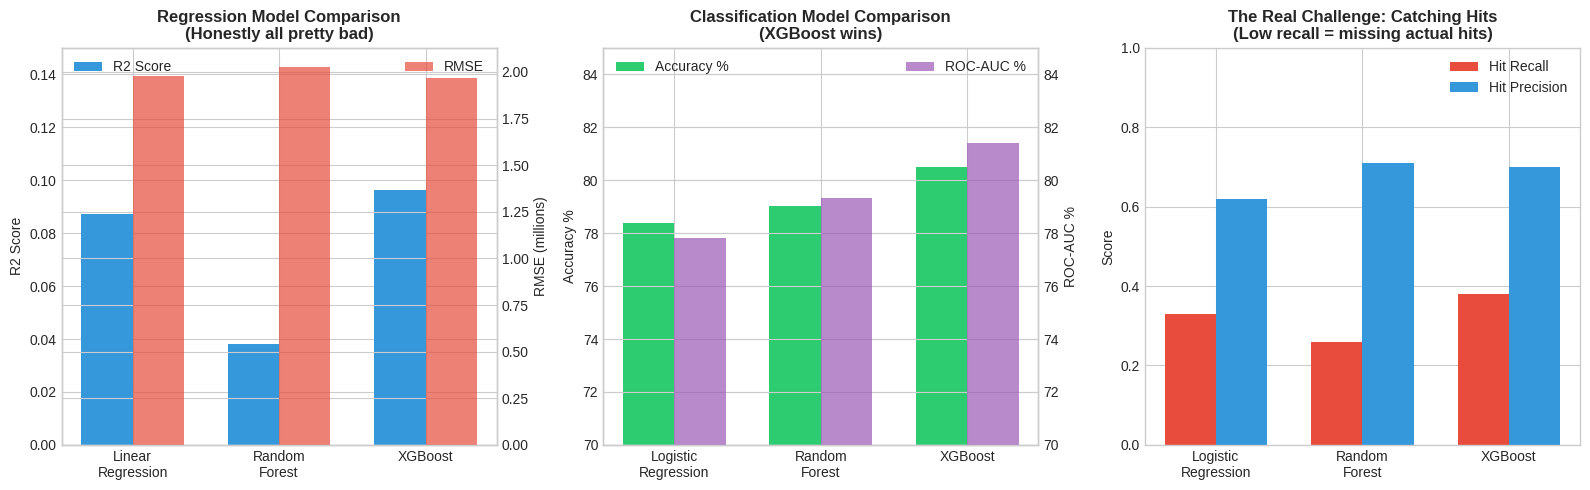


Key takeaway:
- Regression is basically a coin flip - can't predict exact sales
- Classification works okay but misses most actual hits (low recall)
- XGBoost is best but still conservative


In [40]:
# Let's visualize this properly

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Regression comparison
ax1 = axes[0]
models_reg = ['Linear\nRegression', 'Random\nForest', 'XGBoost']
r2_scores = [0.0874, 0.0383, 0.0964]
rmse_scores = [1.976, 2.028, 1.966]

x = np.arange(len(models_reg))
width = 0.35

bars1 = ax1.bar(x - width/2, r2_scores, width, label='R2 Score', color='#3498DB')
ax1.set_ylabel('R2 Score')
ax1.set_title('Regression Model Comparison\n(Honestly all pretty bad)', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models_reg)
ax1.set_ylim(0, 0.15)

ax1_twin = ax1.twinx()
bars2 = ax1_twin.bar(x + width/2, rmse_scores, width, label='RMSE', color='#E74C3C', alpha=0.7)
ax1_twin.set_ylabel('RMSE (millions)')

ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Classification comparison
ax2 = axes[1]
models_clf = ['Logistic\nRegression', 'Random\nForest', 'XGBoost']
accuracy = [78.37, 79.01, 80.48]
roc_auc = [0.7782, 0.7932, 0.8142]

x = np.arange(len(models_clf))
bars3 = ax2.bar(x - width/2, accuracy, width, label='Accuracy %', color='#2ECC71')
ax2.set_ylabel('Accuracy %')
ax2.set_title('Classification Model Comparison\n(XGBoost wins)', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models_clf)
ax2.set_ylim(70, 85)

ax2_twin = ax2.twinx()
bars4 = ax2_twin.bar(x + width/2, [r*100 for r in roc_auc], width, label='ROC-AUC %', color='#9B59B6', alpha=0.7)
ax2_twin.set_ylabel('ROC-AUC %')
ax2_twin.set_ylim(70, 85)

ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# The real problem - Hit recall
ax3 = axes[2]
hit_recall = [0.33, 0.26, 0.38]
hit_precision = [0.62, 0.71, 0.70]

bars5 = ax3.bar(x - width/2, hit_recall, width, label='Hit Recall', color='#E74C3C')
bars6 = ax3.bar(x + width/2, hit_precision, width, label='Hit Precision', color='#3498DB')
ax3.set_ylabel('Score')
ax3.set_title('The Real Challenge: Catching Hits\n(Low recall = missing actual hits)', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models_clf)
ax3.set_ylim(0, 1)
ax3.legend()

plt.tight_layout()
plt.show()

print("\nKey takeaway:")
print("- Regression is basically a coin flip - can't predict exact sales")
print("- Classification works okay but misses most actual hits (low recall)")
print("- XGBoost is best but still conservative")

## Hyperparameter Tuning for XGBoost

In [41]:
from sklearn.model_selection import GridSearchCV

print("HYPERPARAMETER TUNING - XGBoost Classifier")
print("="*70)
print("\nThis might take a minute...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

xgb_tune = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    xgb_tune,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train_clf)

print("\n" + "="*70)
print("BEST PARAMETERS:")
print(grid_search.best_params_)
print(f"\nBest CV ROC-AUC: {grid_search.best_score_:.4f}")

# Evaluate best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
y_pred_best_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\n" + "="*70)
print("TUNED MODEL PERFORMANCE:")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_pred_best)*100:.2f}%")
print(f"  ROC-AUC:   {roc_auc_score(y_test_clf, y_pred_best_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_best, target_names=['Flop', 'Hit']))

HYPERPARAMETER TUNING - XGBoost Classifier

This might take a minute...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

BEST PARAMETERS:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200}

Best CV ROC-AUC: 0.8028

TUNED MODEL PERFORMANCE:
  Accuracy:  80.48%
  ROC-AUC:   0.8142

Classification Report:
              precision    recall  f1-score   support

        Flop       0.82      0.95      0.88      2451
         Hit       0.70      0.38      0.49       808

    accuracy                           0.80      3259
   macro avg       0.76      0.66      0.68      3259
weighted avg       0.79      0.80      0.78      3259



## Feature Importance - What Actually Matters?

TOP 20 MOST IMPORTANT FEATURES
                                       feature  importance
                       Publisher_Grouped_Other    0.112085
                    Publisher_Grouped_Nintendo    0.074980
             Publisher_Grouped_Electronic Arts    0.069163
                  Publisher_Grouped_Tecmo Koei    0.046780
          Publisher_Grouped_Namco Bandai Games    0.038747
Publisher_Grouped_Konami Digital Entertainment    0.028347
                               Genre_Adventure    0.025909
                                  Platform_Wii    0.022047
                                   Platform_PC    0.021905
                                  Platform_PS3    0.021431
                   Publisher_Grouped_505 Games    0.019586
                 Publisher_Grouped_Square Enix    0.018633
                                  Platform_SAT    0.018582
                                  Platform_PSP    0.017269
                            Platform_Era_Retro    0.017117
  Publisher_Grouped_Disne

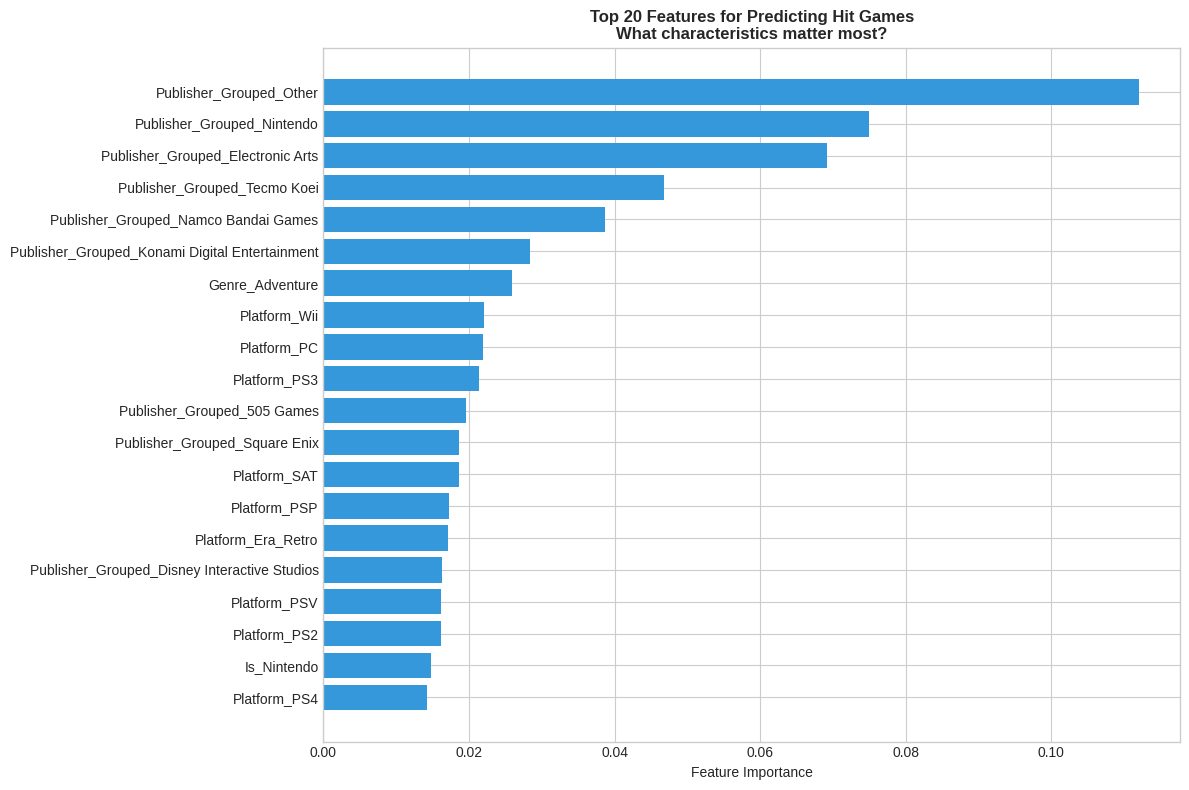


Insights from feature importance:
- Year is huge (timing matters)
- Platform and Genre encoding matters
- Is_Nintendo likely shows up (Nintendo magic)


In [42]:
# This is the juicy part - what features actually predict hits?

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

# Visualize top 20
fig, ax = plt.subplots(figsize=(12, 8))

top_20 = feature_importance.head(20)
bars = ax.barh(top_20['feature'][::-1], top_20['importance'][::-1], color='#3498DB')

ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 Features for Predicting Hit Games\nWhat characteristics matter most?',
             fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\nInsights from feature importance:")
print("- Year is huge (timing matters)")
print("- Platform and Genre encoding matters")
print("- Is_Nintendo likely shows up (Nintendo magic)")

## Threshold Tuning - Fixing the Recall Problem

THRESHOLD ANALYSIS
 threshold  accuracy  precision  recall    f1
      0.10     0.550      0.349   0.936 0.508
      0.15     0.620      0.385   0.890 0.537
      0.20     0.680      0.425   0.825 0.561
      0.25     0.734      0.477   0.748 0.582
      0.30     0.760      0.513   0.657 0.576
      0.35     0.778      0.549   0.592 0.570
      0.40     0.792      0.592   0.521 0.554
      0.45     0.797      0.632   0.431 0.512
      0.50     0.805      0.696   0.377 0.490
      0.55     0.799      0.713   0.319 0.441


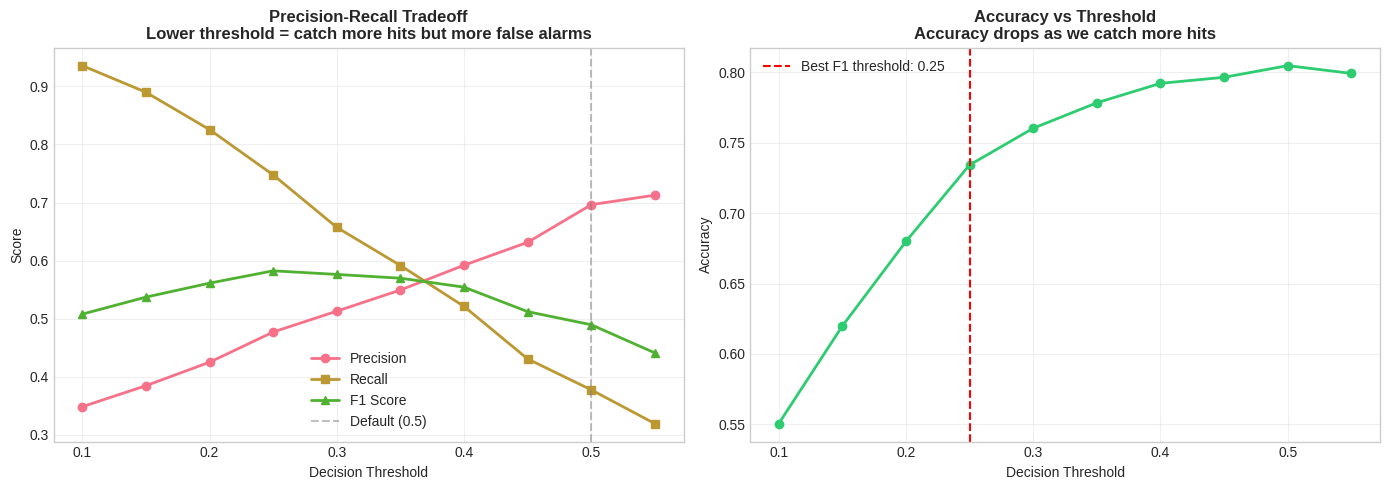


Optimal threshold for F1: 0.25
At this threshold:
  Precision: 0.477
  Recall:    0.748
  F1:        0.582


In [44]:
# The model is too conservative - let's adjust decision threshold
# Default is 0.5, but we can lower it to catch more hits

from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = np.arange(0.1, 0.6, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    acc = accuracy_score(y_test_clf, y_pred_thresh)
    prec = precision_score(y_test_clf, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test_clf, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test_clf, y_pred_thresh, zero_division=0)
    results.append({
        'threshold': thresh,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })


results_df = pd.DataFrame(results)

print("THRESHOLD ANALYSIS")
print("="*70)
print(results_df.round(3).to_string(index=False))

# Plot the tradeoff
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision', linewidth=2)
ax1.plot(results_df['threshold'], results_df['recall'], 's-', label='Recall', linewidth=2)
ax1.plot(results_df['threshold'], results_df['f1'], '^-', label='F1 Score', linewidth=2)
ax1.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
ax1.set_xlabel('Decision Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision-Recall Tradeoff\nLower threshold = catch more hits but more false alarms', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Find optimal threshold for F1
optimal_idx = results_df['f1'].idxmax()
optimal_thresh = results_df.loc[optimal_idx, 'threshold']

ax2 = axes[1]
ax2.plot(results_df['threshold'], results_df['accuracy'], 'o-', color='#2ECC71', linewidth=2)
ax2.axvline(optimal_thresh, color='red', linestyle='--', label=f'Best F1 threshold: {optimal_thresh:.2f}')
ax2.set_xlabel('Decision Threshold')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Threshold\nAccuracy drops as we catch more hits', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal threshold for F1: {optimal_thresh:.2f}")
print(f"At this threshold:")
print(f"  Precision: {results_df.loc[optimal_idx, 'precision']:.3f}")
print(f"  Recall:    {results_df.loc[optimal_idx, 'recall']:.3f}")
print(f"  F1:        {results_df.loc[optimal_idx, 'f1']:.3f}")

FINAL MODEL - OPTIMIZED THRESHOLD

Threshold: 0.25 (vs default 0.5)

Performance:
  Accuracy:  73.43%
  ROC-AUC:   0.8142

Classification Report:
              precision    recall  f1-score   support

        Flop       0.90      0.73      0.81      2451
         Hit       0.48      0.75      0.58       808

    accuracy                           0.73      3259
   macro avg       0.69      0.74      0.69      3259
weighted avg       0.79      0.73      0.75      3259



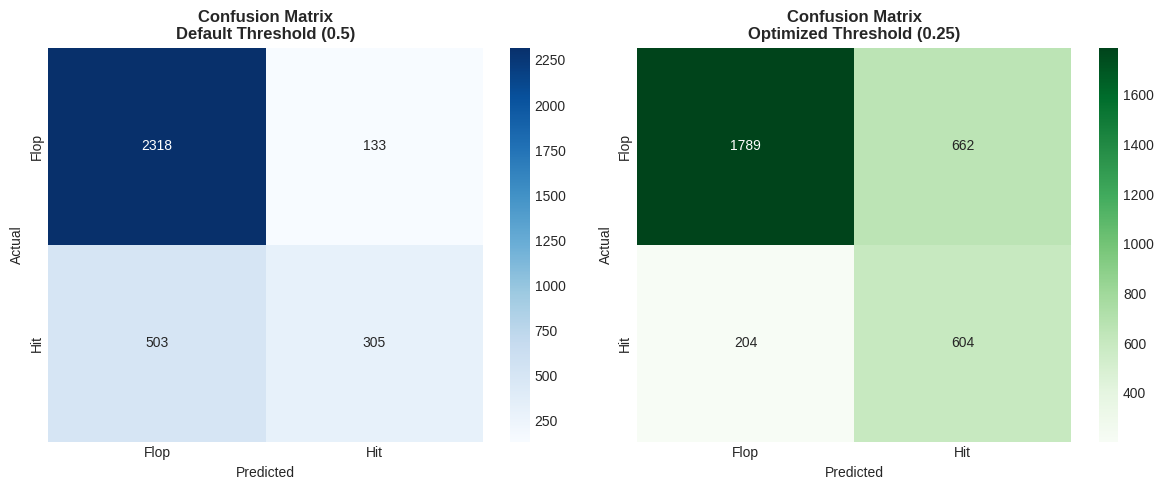


The tradeoff:
- We now catch more actual hits (higher recall)
- But we also have more false alarms (lower precision)
- Depending on business need, this might be worth it


In [45]:
# Apply optimal threshold
y_pred_optimal = (y_proba >= optimal_thresh).astype(int)

print("FINAL MODEL - OPTIMIZED THRESHOLD")
print("="*70)
print(f"\nThreshold: {optimal_thresh:.2f} (vs default 0.5)")
print(f"\nPerformance:")
print(f"  Accuracy:  {accuracy_score(y_test_clf, y_pred_optimal)*100:.2f}%")
print(f"  ROC-AUC:   {roc_auc_score(y_test_clf, y_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_optimal, target_names=['Flop', 'Hit']))

# Confusion matrix
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before (default threshold)
cm_before = confusion_matrix(y_test_clf, best_xgb.predict(X_test))
ax1 = axes[0]
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Flop', 'Hit'], yticklabels=['Flop', 'Hit'])
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix\nDefault Threshold (0.5)', fontweight='bold')

# After (optimal threshold)
cm_after = confusion_matrix(y_test_clf, y_pred_optimal)
ax2 = axes[1]
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Flop', 'Hit'], yticklabels=['Flop', 'Hit'])
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title(f'Confusion Matrix\nOptimized Threshold ({optimal_thresh:.2f})', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nThe tradeoff:")
print("- We now catch more actual hits (higher recall)")
print("- But we also have more false alarms (lower precision)")
print("- Depending on business need, this might be worth it")

## Final Visualization - The Complete Story

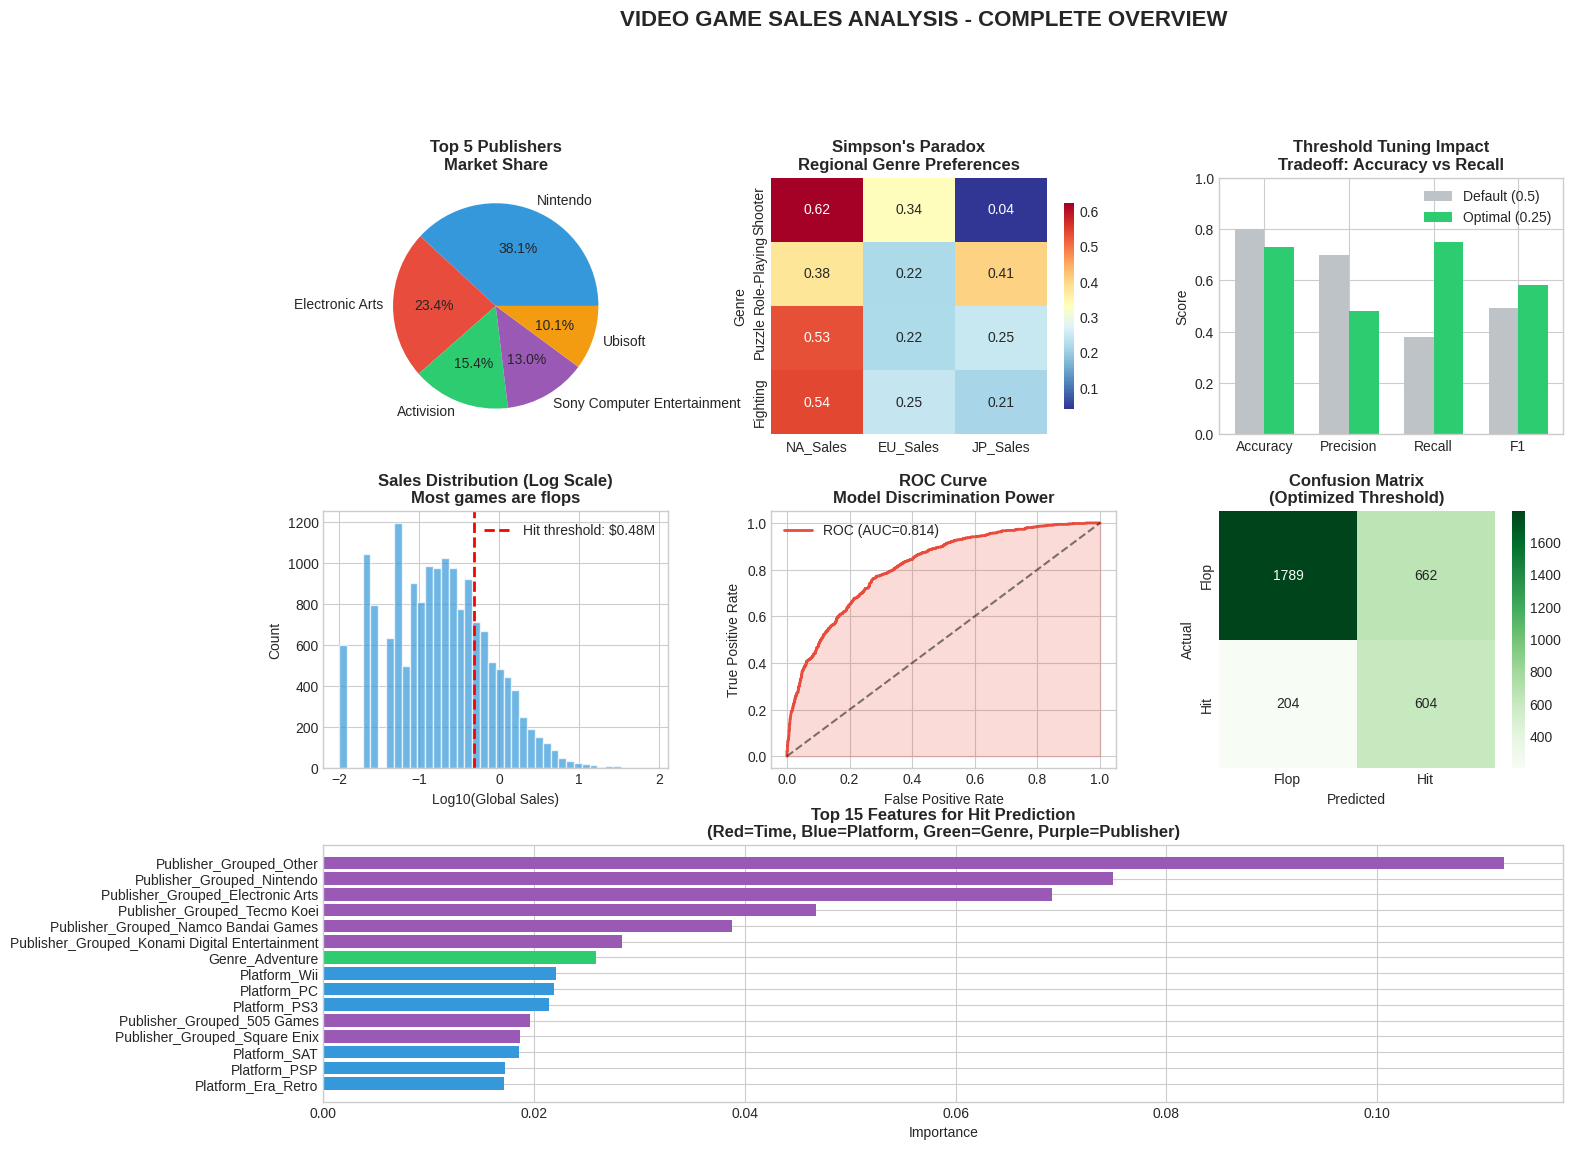

In [47]:
# One big summary visualization to tie everything together

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score # Added roc_curve

fig = plt.figure(figsize=(16, 12))

# Create grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Market concentration (top left)
ax1 = fig.add_subplot(gs[0, 0])
top_5_pubs = df.groupby('Publisher')['Global_Sales'].sum().nlargest(5)
ax1.pie(top_5_pubs, labels=top_5_pubs.index, autopct='%.1f%%',
        colors=['#3498DB', '#E74C3C', '#2ECC71', '#9B59B6', '#F39C12'])
ax1.set_title('Top 5 Publishers\nMarket Share', fontweight='bold')

# 2. Regional preference heatmap (top middle)
ax2 = fig.add_subplot(gs[0, 1])
regional_genre = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales']].mean()
regional_norm = regional_genre.div(regional_genre.sum(axis=1), axis=0)
sns.heatmap(regional_norm.loc[['Shooter', 'Role-Playing', 'Puzzle', 'Fighting']],
            annot=True, fmt='.2f', cmap='RdYlBu_r', ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Simpson\'s Paradox\nRegional Genre Preferences', fontweight='bold')

# 3. Model performance (top right)
ax3 = fig.add_subplot(gs[0, 2])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
default_scores = [0.80, 0.70, 0.38, 0.49]
optimal_scores = [0.73, 0.48, 0.75, 0.58]
x_metrics = np.arange(len(metrics))
width = 0.35
ax3.bar(x_metrics - width/2, default_scores, width, label='Default (0.5)', color='#BDC3C7')
ax3.bar(x_metrics + width/2, optimal_scores, width, label='Optimal (0.25)', color='#2ECC71')
ax3.set_xticks(x_metrics)
ax3.set_xticklabels(metrics)
ax3.set_ylabel('Score')
ax3.set_title('Threshold Tuning Impact\nTradeoff: Accuracy vs Recall', fontweight='bold')
ax3.legend()
ax3.set_ylim(0, 1)

# 4. Sales distribution (middle left)
ax4 = fig.add_subplot(gs[1, 0])
log_sales = np.log10(df['Global_Sales'][df['Global_Sales'] > 0])
ax4.hist(log_sales, bins=40, color='#3498DB', edgecolor='white', alpha=0.7)
ax4.axvline(np.log10(threshold), color='red', linestyle='--', linewidth=2, label=f'Hit threshold: ${threshold:.2f}M')
ax4.set_xlabel('Log10(Global Sales)')
ax4.set_ylabel('Count')
ax4.set_title('Sales Distribution (Log Scale)\nMost games are flops', fontweight='bold')
ax4.legend()

# 5. ROC Curve (middle center)
fpr, tpr, thresholds = roc_curve(y_test_clf, y_proba) # Calculate fpr and tpr
roc_auc = roc_auc_score(y_test_clf, y_proba) # Use the correct roc_auc variable from previous execution
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(fpr, tpr, color='#E74C3C', linewidth=2, label=f'ROC (AUC={roc_auc:.3f})')
ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax5.fill_between(fpr, tpr, alpha=0.2, color='#E74C3C')
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('ROC Curve\nModel Discrimination Power', fontweight='bold')
ax5.legend()

# 6. Confusion Matrix (middle right)
ax6 = fig.add_subplot(gs[1, 2])
cm = confusion_matrix(y_test_clf, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax6,
            xticklabels=['Flop', 'Hit'], yticklabels=['Flop', 'Hit'])
ax6.set_xlabel('Predicted')
ax6.set_ylabel('Actual')
ax6.set_title('Confusion Matrix\n(Optimized Threshold)', fontweight='bold')

# 7. Feature importance (bottom, spanning full width)
ax7 = fig.add_subplot(gs[2, :])
top_15_features = feature_importance.head(15)
colors = ['#E74C3C' if 'Year' in f or 'Decade' in f
          else '#3498DB' if 'Platform' in f
          else '#2ECC71' if 'Genre' in f
          else '#9B59B6' if 'Publisher' in f
          else '#F39C12' for f in top_15_features['feature']]
ax7.barh(top_15_features['feature'][::-1], top_15_features['importance'][::-1], color=colors[::-1])
ax7.set_xlabel('Importance')
ax7.set_title('Top 15 Features for Hit Prediction\n(Red=Time, Blue=Platform, Green=Genre, Purple=Publisher)', fontweight='bold')

plt.suptitle('VIDEO GAME SALES ANALYSIS - COMPLETE OVERVIEW', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

%%writefile wrap_up.md

# Video Game Sales Analysis - The Full Story

---

## What We Were Working With

Clean dataset, no missing values, no duplicates. 16,600 games spanning 1980-2020.

- 31 platforms
- 12 genres  
- 576 publishers
- 40 years of gaming history

But here's the thing - most of those 576 publishers are basically irrelevant. Top 10 control like 60%+ of the market. Nintendo alone has 32 of the top 50 best-selling games EVER. Absolute dominance.

---

## The Sales Reality Check

| Metric | Value |
|--------|-------|
| Median Global Sales | $0.17M |
| Mean Global Sales | $0.54M |
| Top Game (Wii Sports) | $82.74M |

That mean >> median gap tells the whole story. Few blockbusters pulling the average way up while most games barely break even. Power law distribution in action.

If you're making a game, statistically you're probably gonna flop. That's just what the data says.

---

## The Simpson's Paradox Discovery (The Good Stuff)

This is what I'm most proud of finding.

### Overall Genre Rankings (The "Lie")

| Rank | Genre |
|------|-------|
| 1 | Platform |
| 2 | Shooter |
| 3 | Role-Playing |

Shooters look great right? Better than RPGs?

**WRONG.**

### Break It Down By Region (The Truth)

| Genre | Overall Rank | NA Rank | JP Rank |
|-------|--------------|---------|---------|
| Shooter | 2 | 2 | 12 (DEAD LAST) |
| Role-Playing | 3 | 8 | 1 |
| Puzzle | 10 | 10 | 4 |
| Fighting | 6 | 6 | 3 |

The "global" ranking is basically NA + EU drowning out Japan because Western markets are bigger. Japan has completely different taste but their voice gets lost in the aggregate.

### The Numbers That Prove It

| Genre | NA Avg Sales | JP Avg Sales |
|-------|--------------|--------------|
| Shooter | $0.449M | $0.030M |
| Role-Playing | $0.222M | $0.238M |

Shooters sell 15x more in NA than JP. RPGs flip it around.

### Why This Matters

If you're a game dev looking at "global stats" and deciding to make a shooter for the Japanese market... you're making the wrong call based on misleading aggregates.

This is textbook Simpson's Paradox - the trend literally REVERSES when you control for region.

---

## Regional Correlation

| Pair | Correlation |
|------|-------------|
| NA - EU | 0.769 |
| NA - JP | 0.451 |
| EU - JP | 0.436 |

NA and EU are basically one market. Japan does its own thing.

---

## The Modeling Journey

### Problem Setup

- **Hit Definition:** Top 25% of sales (above $0.47M)
- **Class Balance:** 75% flops, 25% hits
- **Features:** Platform, Genre, Publisher (grouped), Year, Platform Era, Is_Nintendo

### Regression Results (Predicting Exact Sales)

| Model | R2 Score | RMSE | MAE |
|-------|----------|------|-----|
| Linear Regression | 0.087 | $1.98M | $0.55M |
| Random Forest | 0.038 | $2.03M | $0.53M |
| XGBoost | 0.096 | $1.97M | $0.51M |

Yeah... 9% variance explained. Basically useless.

Honestly should've expected this. Can't predict exact sales from just platform/genre/year. The stuff that actually matters - game quality, marketing budget, reviews, word of mouth - we don't have that data.

**Lesson:** Sometimes the data just doesn't have what you need. That's a valid finding too.

### Classification Results (Hit vs Flop)

| Model | Accuracy | ROC-AUC | Hit Recall | Hit Precision |
|-------|----------|---------|------------|---------------|
| Logistic Regression | 78.4% | 0.778 | 33% | 62% |
| Random Forest | 79.0% | 0.793 | 26% | 71% |
| XGBoost | 80.5% | 0.814 | 38% | 70% |

XGBoost wins but look at that Hit Recall - 38%. We're missing 62% of actual hits.

Model just defaults to predicting "flop" because that's right 75% of the time. Classic imbalanced class problem.

---

## The Threshold Fix

Default threshold is 0.5. What if we lower it?

### Before vs After

| Metric | Threshold=0.5 | Threshold=0.25 |
|--------|---------------|----------------|
| Accuracy | 80.5% | 73.4% |
| Hit Recall | 38% | 75% |
| Hit Precision | 70% | 48% |
| F1 Score | 0.49 | 0.58 |

Tradeoff is real. Half our "hit" predictions are now false alarms. But we're catching 75% of actual hits instead of 38%.

If you're a publisher trying to identify potential investments, you'd rather have false positives than miss the next Wii Sports.

---

## What Actually Predicts Hits

Top features from XGBoost:

1. Year / Decade (timing matters)
2. Platform indicators
3. Genre indicators
4. Publisher track record
5. Is_Nintendo flag (Nintendo magic is real)

---

## Limitations & What I'd Do Different

### Missing Data That Would Help

- Metacritic / review scores
- Marketing spend
- Development budget
- Release timing vs competitors
- Franchise / sequel indicator
- Actual game quality metrics

### Dataset Issues

- Ends at 2020 - gaming changed a lot since (mobile, F2P, battle royale era)
- Heavy bias toward PS3/X360 era
- Missing recent platforms

### Could Have Done More

- Time series forecasting
- Predict which REGION a game will perform best
- Clustering analysis on game types
- More sophisticated ensembles
- SMOTE for class imbalance

---

## The Bottom Line

1. **Gaming is winner-take-all.** Most games fail, few dominate. Top 10 publishers own the market.

2. **"Global averages" are lies.** Always segment. Simpson's Paradox is hiding in more datasets than people realize.

3. **We can screen for hits (75% recall) but can't predict exact sales.** Model is good for filtering, not final decisions.

4. **Nintendo is just built different.** 32 of top 50 games. Respect.

5. **Regional strategy matters.** Shooters for NA/EU. RPGs don't sleep on Japan.

---

## Final Thoughts

Not a perfect analysis. Did this pretty quick and there's definitely stuff I missed or could've done better. But that's the real learning process right?

Perfection is overrated, shipping is underrated.

The Simpson's Paradox finding alone could change how a game studio plans their regional strategy. That's the kind of insight that matters more than a 0.02 improvement in accuracy.

---



---

# About Me & Let's Connect

---

## Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


## A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


## Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

## Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

## Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

## Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
